<h2 style="color:#696969">Housing, Health, and Happiness <br> Creative extension </h2> 
<h1 style="text-align:center">Effect of different matching methods on the paper's conclusions</h1>

<p>As explained in the readme.md, the paper "Housing, Health, and Hapiness" draws very interesting conclusions from the data they collected. However, it might be that the control and treatment groups used in the paper are not well balanced, meaning that the conclusions are biaised. In this notebook, we will analyse the balance of the original treatment and control groups for 28 carefully selected covariates. We will then use different matching methods to make different control and treatment groups and we will see if these new groups are more balanced than the original ones for the 28 selected covariates. For each of these new matched groups, tables 4 and 6 related to cement floor coverage and maternal happiness will be replicated (as for milestone P2) and the significance of the treatment effect will be re-evaluated.</p>

<h2>Matching methods</h2>
<p>For this creative extension, we decided to use the <strong>propensity score matching</strong> method as well as the <strong>caliper matching</strong> method with epsilon equal to 0.05, 0.01, 0.001 and 0.0001.</p>

<h2>Covariates</h2>
<p> We selected <strong>28 covariates</strong> that, in our view, are unrelated to the treatment, making them good candidates for balancing the groups. These covariates can be grouped into 5 household-related categories as follows:</p>
<br>
<strong> Demographic covariates (12):</strong>
<ul>
    <li>S_HHpeople: 2005 Survey - Number of household members</li>
    <li>S_headage: 2005 Survey - Head of household's age</li>
    <li>S_spouseage: 2005 Survey - Spouse's age</li>
    <li>S_headeduc 2005 Survey - Head of household's years of schooling</li>
    <li>S_dem1: 2005 Survey - Proportion of Males 0-5yrs in household</li>
    <li>S_dem2: 2005 Survey - Proportion of Males 6-17yrs in household</li>
    <li>S_dem3: 2005 Survey - Proportion of Males 18-49yrs in household</li>
    <li>S_dem4: 2005 Survey - Proportion of Males 50+yrs in household</li>
    <li>S_dem5: 2005 Survey - Proportion of Females 0-5yrs in household</li>
    <li>S_dem6: 2005 Survey - Proportion of Females 6-17yrs in household</li>
    <li>S_dem7: 2005 Survey - Proportion of Females 18-49yrs in household</li>
    <li>S_dem8: 2005 Survey - Proportion of Females 50+yrs in household</li>
</ul>

<strong> Housing covariates (4):</strong>
<ul>
    <li>S_rooms: 2005 Survey - Number of rooms</li>
    <li>S_waterland: 2005 Survey - Water connection (=1)</li>
    <li>S_waterhouse: 2005 Survey - Water connection inside the house (=1)</li>
    <li>S_electricity 2005 Survey - Electricity (=1)</li>
</ul>
<strong> Economic covariates (5):</strong>
<ul>
    <li>S_incomepc: 2005 Survey - Total household income per capita</li>
    <li>S_assetspc: 2005 Survey - Total value of household assets per capita</li>
    <li>S_shpeoplework: 2005 Survey - Proportion of household members who work</li>
    <li>S_microenter: 2005 Survey - Household operates a microenterprise (=1)</li>
    <li>S_hrsworkedpc: 2005 Survey - Hours worked by household members per capita</li>
</ul>
<strong> Hygienic covariates (4):</strong>
<ul>
    <li>S_hasanimals: 2005 Survey - Household has animals on land (=1)</li>
    <li>S_animalsinside: 2005 Survey - Animals allowed to enter the house (=1)</li>
    <li>S_garbage: 2005 Survey - Uses garbage collection service (=1)</li>
    <li>S_washhands: 2005 Survey - Number of times respondent washed hands the day before</li>
</ul>
<strong> Social assistance covariates (3):</strong>
<ul>
    <li>S_cashtransfers: 2005 Survey - Transfers per capita from government programs</li>
    <li>S_milkprogram: 2005 Survey - Household beneficiary of government milk supplement program (=1)</li>
    <li>S_foodprogram: 2005 Survey - Household beneficiary of government food program (=1)</li>
</ul>

<h2>Selected paper outcomes</h2>
<p>The paper evaluates the effect of the treatment for a wide range of outcomes. For this creative extension, we decided to focus on the outcomes present in <strong>tables 4 and 6</strong>. These outcomes represent measures of cement floor coverage as well as maternal satisfaction and happiness. For each matching method, we will re-evaluate tables 4 and 6 in order to see if the treatment effect on these outcomes is still significant.</p>

<h2> Notebook organization</h2>
<p>The notebook is organized into four parts:<br>
    
<strong>Part 0</strong> contains all the functions we created to match treatment and control groups, visualize covariate balance, and display tables 4 and 6. The data and all necessary libraries are also imported.<br>
    
<strong>Part 1</strong> serves as a reference. It shows the balance of the 28 covariates for the treatment and control groups used in the paper. It also shows tables 4 and 6 obtained when using these groups. The tables are exactly the same as what we obtained for the replication task of milestone P2.<br>

<strong>Part 2</strong> shows the balance of the 28 covariates for the treatment and control groups created via different matching methods. This balance is then compared with part 1 (the reference). Tables 4 and 6 are also re-evaluated and compared with the tables of part 1. For each matching method, we will follow the following steps:</p>
<strong>a) Description of the matching method</strong><br>
<strong>b) Visualization of the new covariate balance</strong><br>
<strong>c) Re-evaluation of tables 4 and 6</strong><br>
<strong>d) Discussion of the results and comparisons</strong><br>

<strong>Part 3</strong> is the conclusion. It is what we conclude from our creative extension.

<h1 style="text-align:center">Part 0 | Function definitions and data import</h1>


In [2]:
import warnings
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline

# Mute warnings
warnings.simplefilter(action='ignore')

<p>Function definitions for the matching methods:</p>

In [3]:
# Outputs similarity given propensity scores with a highest similarity of 1
def get_similarity(propensity_score1, propensity_score2):
    return 1-np.abs(propensity_score1 - propensity_score2)


# Outputs balanced treated and control dataframes after propensity score
# matching (caliper matching with epsilon = 1) or caliper matching given
# any epsilon as input
def matching(epsilon = 1):
    
    # Separate the treatment and control households
    treated_propensity = household_data[household_data['dpisofirme']==1]
    control_propensity = household_data[household_data['dpisofirme']==0]
    
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Loop through all the pairs of treated and control households
    for control_index, control_row in control_propensity.iterrows():
        for treatment_index, treatment_row in treated_propensity.iterrows():
    
            # Calculate the similarity
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])
            
            if similarity > 1-epsilon:
                # Add an edge between the two households weighted by the
                # similarity between them
                G.add_weighted_edges_from([(control_index, 
                                            treatment_index, 
                                            similarity)])
    
    # Return the maximum weighted matching on the generated graph
    matching = nx.max_weight_matching(G)
    
    # Isolate the dataframe with matching propensity scores
    matching = dict(matching)
    balanced_df = household_data.loc[list(matching.keys()) + list(matching.values())]
    
    return balanced_df

<p>Function definitions for the visualization of covariates balance:</p>

In [18]:
# This function allows to compare the covariate balance between control and 
# treatment groups visually. It creates histograms for discrete and 
# continuous covariates and bar plots for binary covariates.
# Histograms have kernel density functions and are replaced by boxplots if 
# the last argument is True (boxplot = True). Barplots have error bars
# corresponding to bootstrapped 95% confidence intervals.
# The inputs are covars: list of the covariates, covars_binary: list of the covariates 
# that are binary, df_treat: treatment dataframe, df_contr: control dataframe, 
# axes: list of matplotlib axes, df: complete dataframe, boxplot: boolean.
def visualize_balance(covars, covars_binary, df_treat, df_contr, axes, df, boxplot=False):
    
    for i in range(0, len(covars)):
        covariate = covars[i]

        if (covariate in covars_binary): # Check if covariate is binary
            if not boxplot:
                sns.barplot(data=df, x="dpisofirme", y=covariate, estimator=np.mean,
                            ax=axes[i], ci=95, n_boot=1000,
                            palette="pastel") # Bootstrapped 95% CI as error bars
                axes[i].set(ylabel = "Proportion of 'Yes' for " + covariate)   
            else:
                # If covariate is binary and boxplot=True, nothing is plotted. 
                # Indeed, boxplots make no sense for binary covariates
                continue 
        else:
            if boxplot:
                with sns.axes_style("whitegrid"):
                     sns.boxplot(data=df, x="dpisofirme", y=covariate, ax = axes[i],
                                 palette="pastel")
            else:
                sns.distplot(df_treat[covariate].dropna(), ax=axes[i], label="treatment")
                sns.distplot(df_contr[covariate].dropna(), ax=axes[i], label="control")
                axes[i].set(xlabel=covariate, ylabel=covariate+" density")
                axes[i].legend()

                
# This function allows to plot a big figure containing the visualizations of all the
# covariate balance i.e demographic, housing, economic, hygienic and social covariates.
# It uses the function visualize_balance.
# Inputs are the treated and control dataframe as well as the complete dataframe
def visualize_balance_all(treat, contr, household_df):
    
    # Demographic covariates
    dem_covariates = ["S_HHpeople", "S_headage", "S_spouseage", "S_headeduc","S_dem1",
                  "S_dem2", "S_dem3", "S_dem4", "S_dem5", "S_dem6", "S_dem7", "S_dem8"]
    dem_binary = [] # No binary demographic covariates
    
    # Create figure with 12 axes for the 12 demographic covariates and call the function
    # visualize_balance
    fig1, dem_axes = plt.subplots(4,3, figsize=(14,11));
    dem_axes = dem_axes.flat # Tranform 2D-array into 1D-array
    visualize_balance(dem_covariates, dem_binary, treat, contr, dem_axes, household_df)
    fig1.suptitle('Balance between control and treatment groups for the 12 demographic covariates\n Histograms and corresponding Boxplots', y=1.05, fontsize=18)
    fig1.tight_layout()
    
    # Create figure with 12 axes for the 12 demographic covariates and call the function
    # visualize_balance with boxplot=True
    fig1_, dem_axes_ = plt.subplots(4,3, figsize=(14,11));
    dem_axes_ = dem_axes_.flat # Tranform 2D-array into 1D-array
    visualize_balance(dem_covariates, dem_binary, treat, contr, dem_axes_, household_df, True)
    fig1_.tight_layout()

    
    # Housing covariates
    hous_covariates = ["S_rooms", "S_waterland", "S_waterhouse", "S_electricity"]
    hous_binary = ["S_waterland", "S_waterhouse", "S_electricity"]

    # Create a figure with 4 axes for the 4 housing covariates and call the function
    # visualize_balance
    fig2, hous_axes = plt.subplots(1,4, figsize=(16,4)) # Create 4 axes
    visualize_balance(hous_covariates, hous_binary, treat, contr, hous_axes, household_df)
    fig2.suptitle('Balance between control and treatment groups for the 4 housing covariates\n Histograms and corresponding Boxplots\n (Barcharts only for binary covariates)', y=1.15, fontsize=18)
    fig2.tight_layout()
    
    # Create a figure with 4 axes for the 4 housing covariates and call the function 
    # visualize_balance with boxplot=True
    fig2_, hous_axes_ = plt.subplots(1,4, figsize=(16,4)) # Create 4 axes
    visualize_balance(hous_covariates, hous_binary, treat, contr, hous_axes_, household_df, True)
    fig2_.tight_layout()

    
    # Economic covariates
    econ_covariates = ["S_incomepc", "S_assetspc", "S_shpeoplework", "S_microenter",
                       "S_hrsworkedpc"]
    econ_binary = ["S_microenter"]

    # Create a figure with 5 axes for the 5 economic covariates and call the function 
    # visualize_balance
    fig3, econ_axes = plt.subplots(2,3, figsize=(16,6)) # Creates 6 axes
    fig3.delaxes(econ_axes[1][2]) # Deletes unnecessary axis (5 covariates vs 6 axes)
    econ_axes = econ_axes.flat # Tranforms 2D-array into 1D-array
    visualize_balance(econ_covariates, econ_binary, treat, contr, econ_axes, household_df)
    fig3.suptitle('Balance between control and treatment groups for the 5 economic covariates\n Histograms and corresponding Boxplots\n (Barcharts only for binary covariates)', y=1.15, fontsize=18)
    fig3.tight_layout()
    
    # Create a figure with 5 axes for the 5 economic covariates and call the function 
    # visualize_balance with boxplot=True
    fig3_, econ_axes_ = plt.subplots(2,3, figsize=(16,6)) # Creates 6 axes
    fig3_.delaxes(econ_axes_[1][2]) # Deletes unnecessary axis (5 covariates vs 6 axes)
    econ_axes_ = econ_axes_.flat # Tranforms 2D-array into 1D-array
    visualize_balance(econ_covariates, econ_binary, treat, contr, econ_axes_, household_df, True)
    fig3_.tight_layout()

    # Hygienic covariates
    hyg_covariates = ["S_hasanimals", "S_animalsinside", "S_garbage", "S_washhands"]
    hyg_binary = ["S_hasanimals", "S_animalsinside", "S_garbage"]
    
    # Create a figure with 4 axes for the 4 hygienic covariates and call the function
    # visualize_balance
    fig4, hyg_axes = plt.subplots(1,4, figsize=(16,4)) # Creates 4 axes
    visualize_balance(hyg_covariates, hyg_binary, treat, contr, hyg_axes, household_df)
    fig4.suptitle('Balance between control and treatment groups for the 4 hygienic covariates\n Histograms and corresponding Boxplots\n(Barcharts only for binary covariates)', y=1.15, fontsize=18)
    fig4.tight_layout()
    
    # Create a figure with 4 axes for the 4 hygienic covariates and call the function 
    # visualize_balance with boxplot=True
    fig4_, hyg_axes_ = plt.subplots(1,4, figsize=(16,4)) # Creates 4 axes
    visualize_balance(hyg_covariates, hyg_binary, treat, contr, hyg_axes_, household_df, True)
    fig4_.tight_layout()

    # Social covariates
    soc_covariates = ["S_cashtransfers", "S_milkprogram", "S_foodprogram"]
    soc_binary = ["S_milkprogram", "S_foodprogram"]

    # Create a figure with 3 axes for the 3 social covariates and call the function
    # visualize_balance
    fig5, soc_axes = plt.subplots(1,3, figsize=(16,4)) # Creates 3 axes
    visualize_balance(soc_covariates, soc_binary, treat, contr, soc_axes, household_df)
    fig5.suptitle('Balance between control and treatment groups for the 3 social assistance covariates\n Histograms and corresponding Boxplots\n (Barcharts only for binary covariates)', y=1.15, fontsize=18)
    fig5.tight_layout() 

    # Create a figure with 3 axes for the 3 social covariates and call the function
    # visualize_balance with boxplot=True
    fig5_, soc_axes_ = plt.subplots(1,3, figsize=(16,4)) # Creates 3 axes
    visualize_balance(soc_covariates, soc_binary, treat, contr, soc_axes_, household_df, True)
    fig5_.tight_layout() 

<p>Function definitions for the creation and display of Tables 4 and 6:</p>

In [7]:
# This function outups least square linear regression results (estimated 
# coefficient, clustered standard error, p-value, percentage compared to 
# control) given outcome variable (LHS of equation) and predictors (RHS)
def regression_results(outcome, predictors, data):
    
    model = smf.ols(formula = outcome + '~' + predictors, 
                    data = data)
    results = model.fit(method = 'pinv', 
                        cov_type = 'cluster', 
                        cov_kwds = {'groups' : data['idcluster']})
    coeff = results.params[1]
    std = results.bse[1]
    p_value = results.pvalues[1]
    percent = 100 * coeff/control_means[outcome]
    
    return np.around(coeff,3), np.around(std,3), p_value, np.around(percent,3)


# For each outcome variable, outputs control means and standard deviations as
# well as regression results for each model (coefficients, standard deviations,
# percentages and p-values) given the balanced input dataframe
def final_results(data):
    
    # Compute mean and standard deviation for control group
    control_means = data[data['dpisofirme']==0][outcome_variables].mean()
    control_stds = data[data['dpisofirme']==0][outcome_variables].std()
    
    # Initialize empty arrays for regression results
    coeff1 = [0]*outcome_length
    std1 = [0]*outcome_length
    pval1 = [0]*outcome_length
    percent1 = [0]*outcome_length
    coeff2 = [0]*outcome_length
    std2 = [0]*outcome_length
    pval2 = [0]*outcome_length
    percent2 = [0]*outcome_length
    coeff3 = [0]*outcome_length
    std3 = [0]*outcome_length
    pval3 = [0]*outcome_length
    percent3 = [0]*outcome_length
    
    # Define predictor variables
    model1_predictors = treatment_indicator
    model2_predictors = treatment_indicator + '+' + demog_controls1 + '+'\
                        + demog_controls2 + '+' + health_controls
    model3_predictors = treatment_indicator + '+' + demog_controls1 + '+'\
                        + demog_controls2 + '+' + health_controls + '+'\
                        + social_controls
    
    # Extract regression results
    for i in range(outcome_length):
        coeff1[i], std1[i], pval1[i], percent1[i]\
        = regression_results(outcome_variables[i], model1_predictors, data)
    for i in range(outcome_length):
        coeff2[i], std2[i], pval2[i], percent2[i]\
        = regression_results(outcome_variables[i], model2_predictors, data)
    for i in range(outcome_length):
        coeff3[i], std3[i], pval3[i], percent3[i]\
        = regression_results(outcome_variables[i], model3_predictors, data)
    
    # Create a DataFrame where all results are summarized
    results = pd.DataFrame({'Dependent variable' : 
                            ['Share of rooms with cement floors', 
                             'Cement floor in kitchen', 
                             'Cement floor in dining room', 
                             'Cement floor in bathroom', 
                             'Cement floor in bedroom',
                             'Satisfaction with floor quality', 
                             'Satisfaction with house quality', 
                             'Satisfaction with quality of life', 
                             'Depression scale (CES-D scale)', 
                             'Perceived stress scale (PSS)'], 
                            'Control group mean' : np.around(control_means, 3), 
                            'Control group std' : np.around(control_stds, 3), 
                            'Model 1 coeff' : coeff1, 
                            'Model 1 std' : std1, 
                            'Model 1 percent' : percent1, 
                            'Model 1 p-value' : pval1, 
                            'Model 2 coeff' : coeff2, 
                            'Model 2 std' : std2, 
                            'Model 2 percent' : percent2,
                            'Model 2 p-value' : pval2, 
                            'Model 3 coeff' : coeff3, 
                            'Model 3 std' : std3, 
                            'Model 3 percent' : percent3, 
                            'Model 3 p-value' : pval3, 
                           })
    
    results.set_index('Dependent variable', inplace=True)
    
    return results

<p>Loading and preprocessing of the data + separation of control and treatment groups</p>

In [8]:
# Load the data
household_data = pd.read_stata('Data/PisoFirme_AEJPol-20070024_household.dta')

# Drop households with missing values in idcluster
household_data.dropna(axis=0, subset=['idcluster'], inplace=True)

# Impute missing values in covariates with zero
household_data.fillna(0, inplace=True)

# Separate into control and treatment groups
control = household_data[household_data['dpisofirme']==0]
treated = household_data[household_data['dpisofirme']==1]

Initialization of the 3 regression models used to compute Table 4 and 6 as described in the paper

In [9]:
# Define the outcome variables to be predicted (LHS of equation)
outcome_variables = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin',
                     'S_cementfloorbat', 'S_cementfloorbed', 'S_satisfloor',
                     'S_satishouse', 'S_satislife', 'S_cesds', 'S_pss']

# Compute mean and standard deviation for outcome variables
control_means = control[outcome_variables].mean()
control_stds = control[outcome_variables].std()

# Define outcome length (to loop in outcome_variables later)
outcome_length = len(outcome_variables)

# Model 1 (no controls)
treatment_indicator = 'C(dpisofirme)'

# Model 2 (adds demographic and health controls)
demog_controls1 = 'S_HHpeople + S_rooms + S_headeduc + S_spouseeduc\
                   + S_headage + S_spouseage'
demog_controls2 = 'S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6\
                   + S_dem7 + S_dem8'
health_controls = 'C(S_hasanimals) + C(S_animalsinside) + C(S_waterland)\
                   + C(S_waterhouse) + C(S_electricity) + S_washhands\
                   + C(S_garbage)'

# Model 3 (adds controls for public social programs)
social_controls = 'S_cashtransfers + C(S_milkprogram) + C(S_foodprogram)\
                   + C(S_seguropopular)'

<h1 style="text-align:center">Part 1 | Original balance and tables</h1>


<p>This part shows the balance of the 28 selected covariates for the treatment and control groups used in the paper i.e. <strong>1393</strong> data points for the <strong>control</strong> and <strong>1362</strong> for the <strong>treatment</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

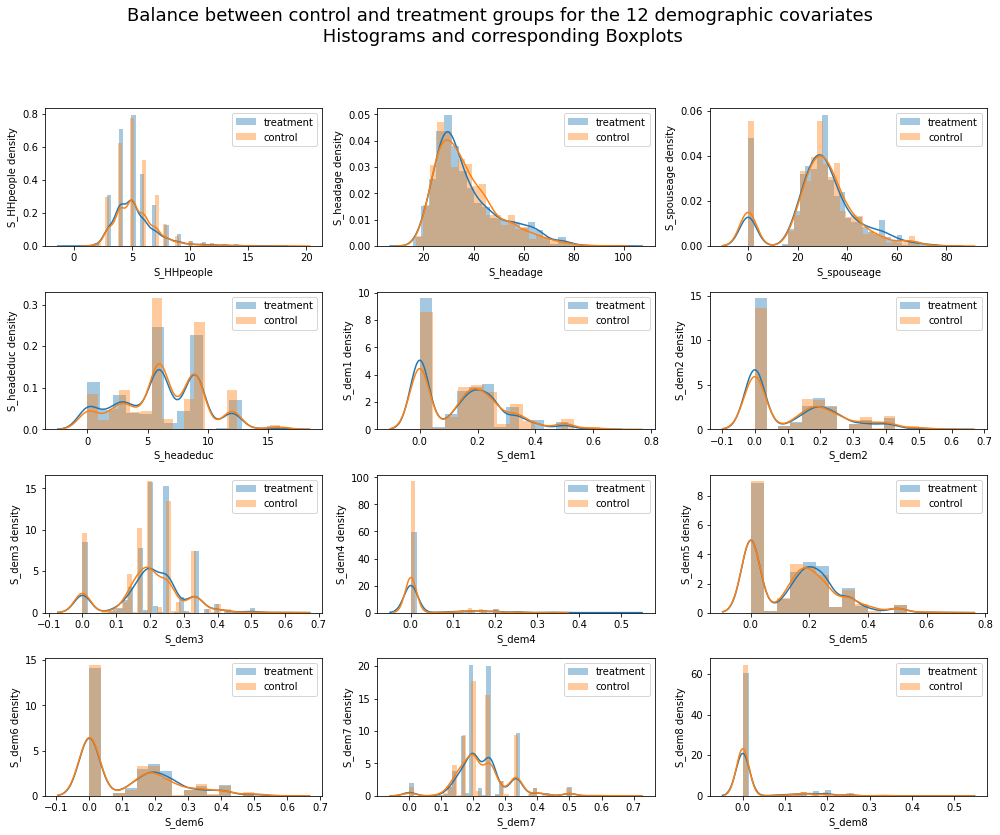

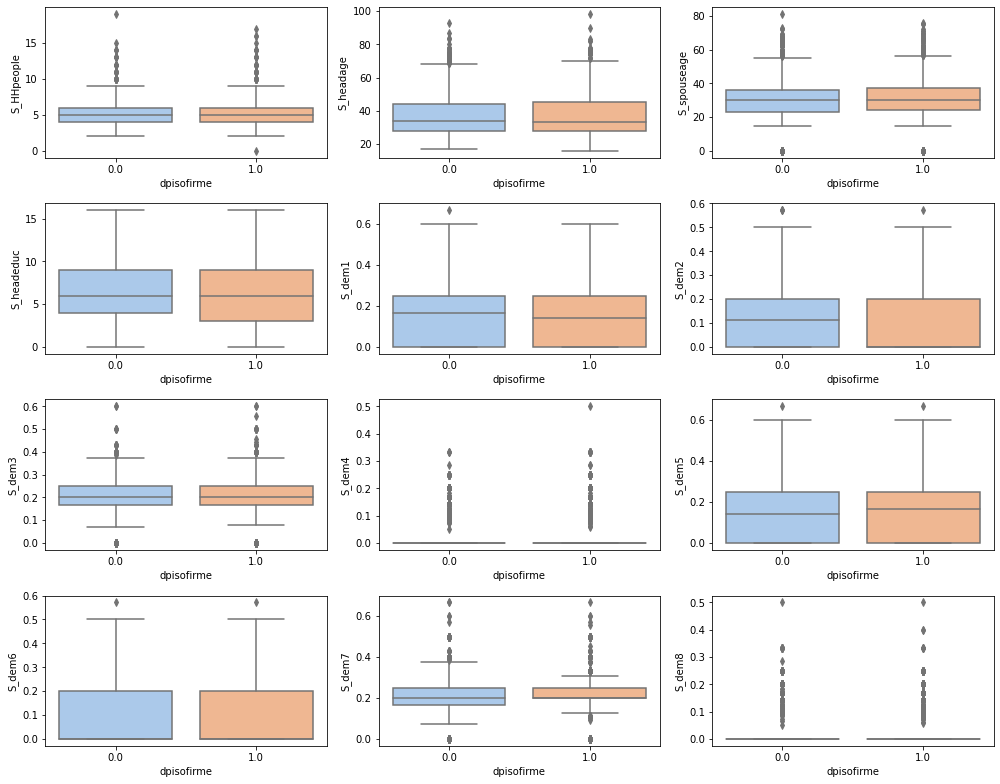

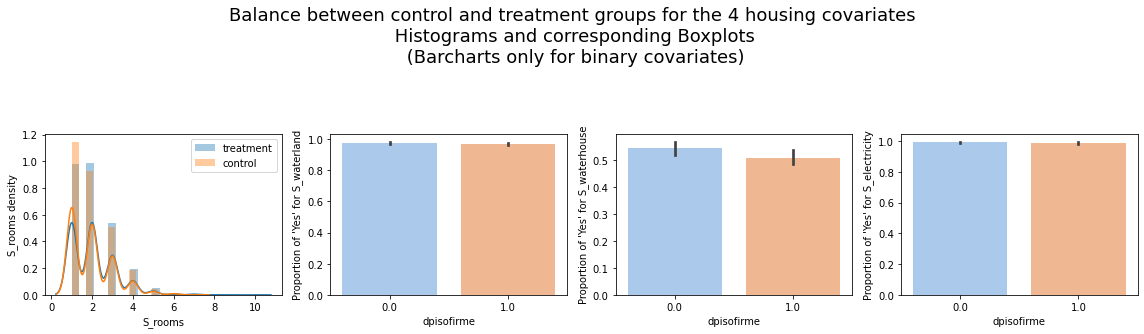

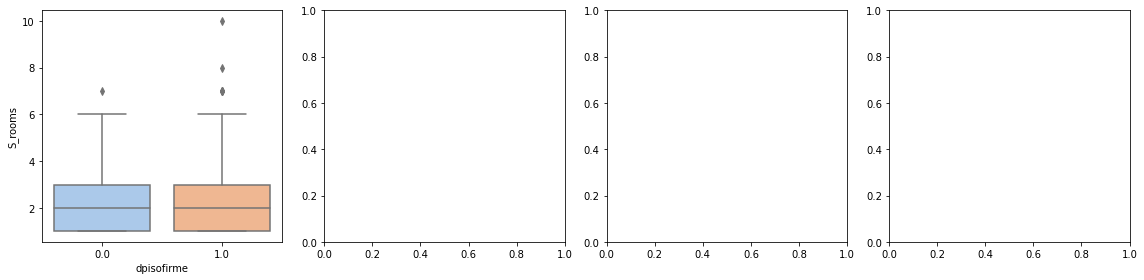

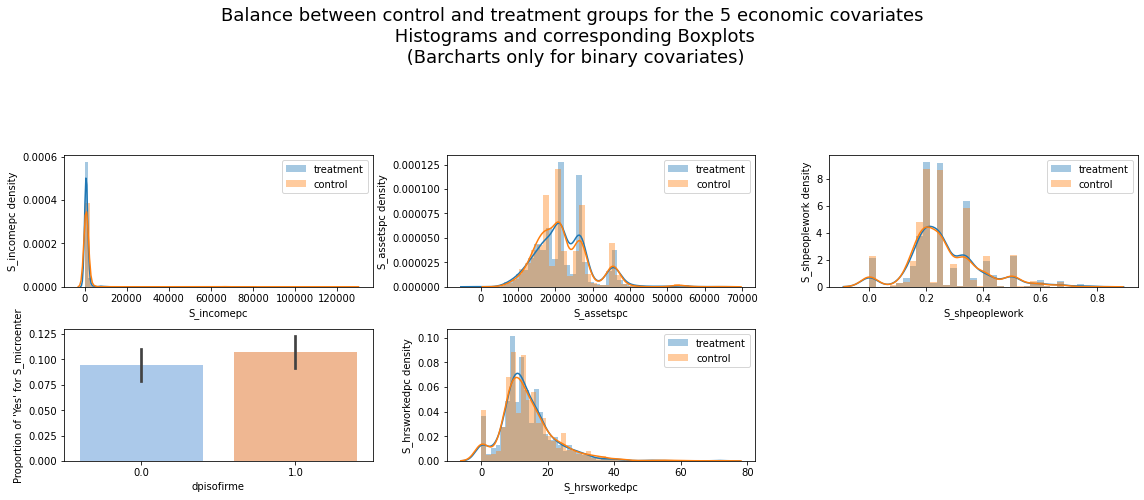

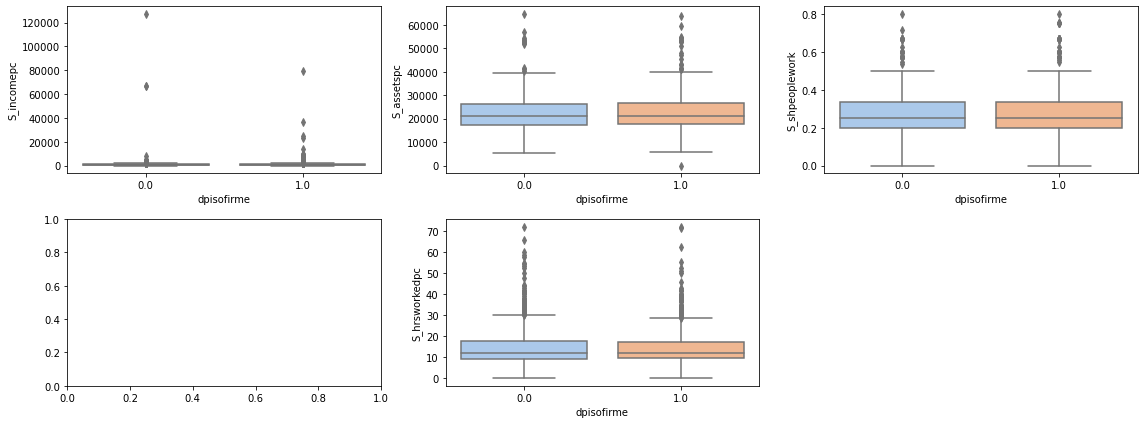

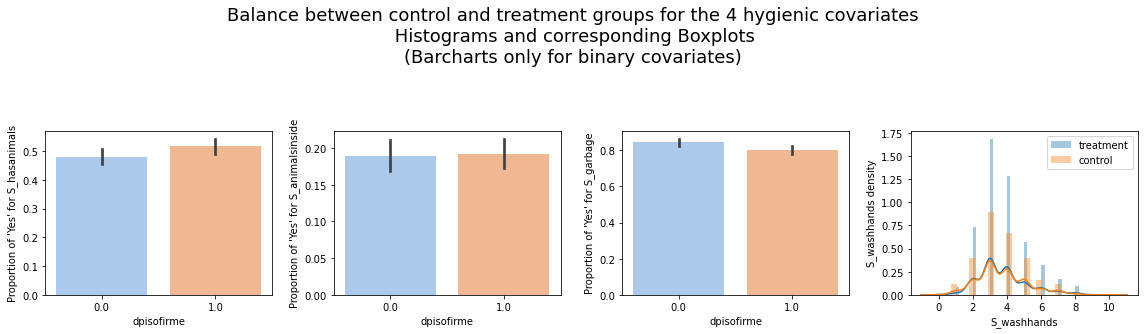

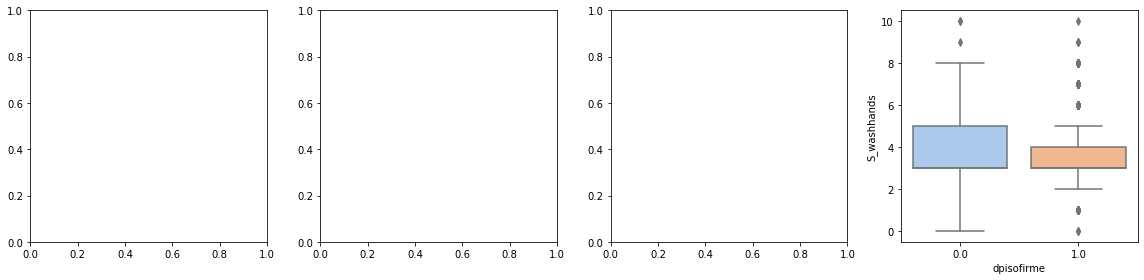

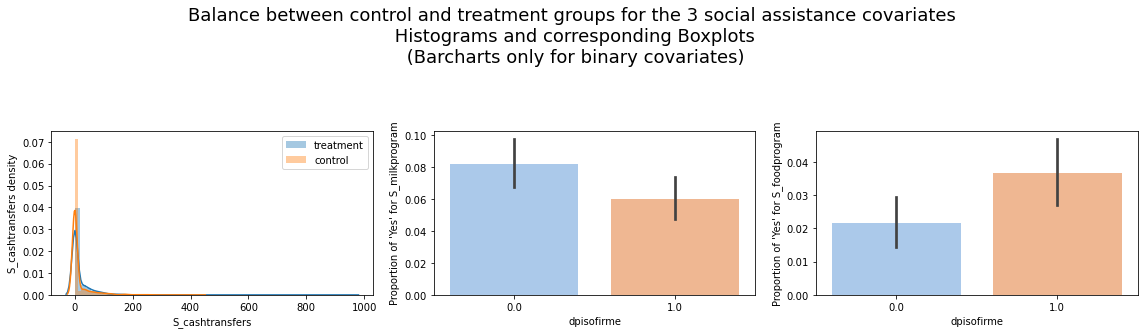

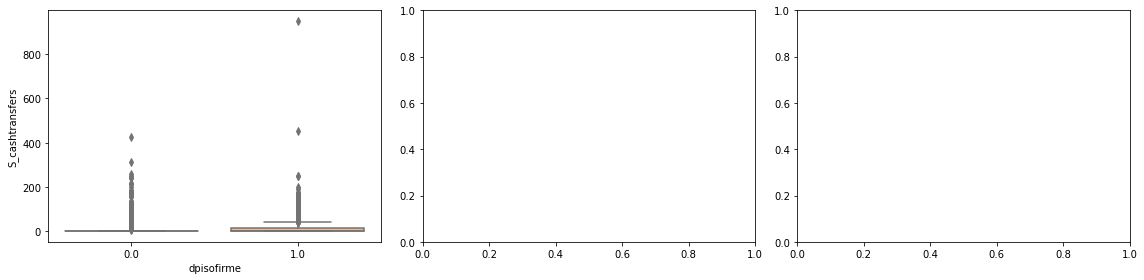

In [19]:
visualize_balance_all(treated, control, household_data)

In [8]:
final_results(household_data)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.728000,0.363,0.202,0.021,27.746,9.720879e-23,0.203,0.019,27.876,1.281580e-27,0.205,0.018,28.218,6.398380e-29
Cement floor in kitchen,0.671000,0.470,0.255,0.025,37.936,4.154648e-25,0.254,0.022,37.896,9.616616e-32,0.259,0.022,38.601,6.765287e-32
Cement floor in dining room,0.709000,0.455,0.210,0.026,29.633,1.976432e-16,0.212,0.024,29.888,2.445365e-18,0.216,0.024,30.469,5.660023e-19
Cement floor in bathroom,0.803000,0.398,0.105,0.022,13.071,1.419663e-06,0.108,0.018,13.484,1.379823e-09,0.112,0.018,13.958,2.129163e-10
Cement floor in bedroom,0.668000,0.471,0.238,0.020,35.598,2.280973e-32,0.243,0.020,36.371,5.459423e-34,0.242,0.019,36.299,6.185384e-36
Satisfaction with floor quality,0.511000,0.500,0.219,0.023,42.784,4.719955e-21,0.217,0.023,42.546,6.921387e-21,0.216,0.025,42.272,1.975831e-18
Satisfaction with house quality,0.605000,0.489,0.092,0.021,15.136,1.309931e-05,0.080,0.020,13.265,8.288139e-05,0.077,0.022,12.750,3.814440e-04
Satisfaction with quality of life,0.601000,0.490,0.112,0.022,18.650,2.463076e-07,0.104,0.020,17.319,1.933480e-07,0.105,0.021,17.431,6.189990e-07
Depression scale (CES-D scale),18.466000,9.450,-2.344,0.603,-12.694,1.019280e-04,-2.424,0.561,-13.129,1.548883e-05,-2.389,0.556,-12.939,1.733905e-05


<strong>Discussion:</strong>
<p>We can see that all the covariates are already relatively well balanced. However, it could still be improved. By replicating tables 4 and 6, we obtain the same results as in milestone P2. All the coefficients are statistically significant at 1 percent level as shown by the extremely small p-values.</p>

<h1 style="text-align:center" id="Propensity">Part 2 | Matching method balances and tables</h1>


<h2 style="text-align:center" id="Propensity">2.1 Propensity score matching method</h2>


<strong>a) description</strong>

<p>
We first use logistic regression to predict and assign a propensity score to each of the data points (the propensity score represents the probability for each household of receiving the treatment, based on the 28 pre-treatment features that we selected).
</p>

In [9]:
# We build the logistic regression model to predict the outcome variable
# 'dpisofirme' with the chosen 28 covariates
mod = smf.logit(formula='dpisofirme ~ S_HHpeople + S_headage + S_spouseage\
                         + S_headeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4\
                         + S_dem5 + S_dem6 + S_dem7 + S_dem8 + S_rooms\
                         + C(S_waterland) + C(S_waterhouse) + C(S_electricity)\
                         + S_incomepc + S_assetspc + S_shpeoplework\
                         + C(S_microenter) + S_hrsworkedpc + C(S_hasanimals)\
                         + C(S_animalsinside) + C(S_garbage) + S_washhands\
                         + S_cashtransfers + C(S_milkprogram)\
                         + C(S_foodprogram)',
                data=household_data)

res = mod.fit()

# Extract the estimated propensity scores (probability of dpisofirme = 1)
# for each household
household_data['Propensity_score'] = res.predict()

         Current function value: 0.673647
         Iterations: 35


(1362, 1362)

<p>
We then find the treatment and control pairs that maximize similarity, which is equal to 1 - |propensity(treated) - propensity(control)|. We here use the classical matching approach with epsilon = 1.
<\p>

In [ ]:
# Isolate the dataframe with matching propensity scores
balanced_propensity = matching()

# Extract balanced treated and control from matched dataframe
treated_balanced_propensity = balanced_propensity[balanced_propensity['dpisofirme']==1]
control_balanced_propensity = balanced_propensity[balanced_propensity['dpisofirme']==0]

# Display the length of treated and control households
len(treated_balanced_propensity), len(control_balanced_propensity)

<strong>b) covariate balance visualization</strong>

<p>This matching created a treatment and control group of same size. <strong>1362</strong> datapoints for the <strong>treatment</strong> and <strong>1362</strong> for the <strong>control</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

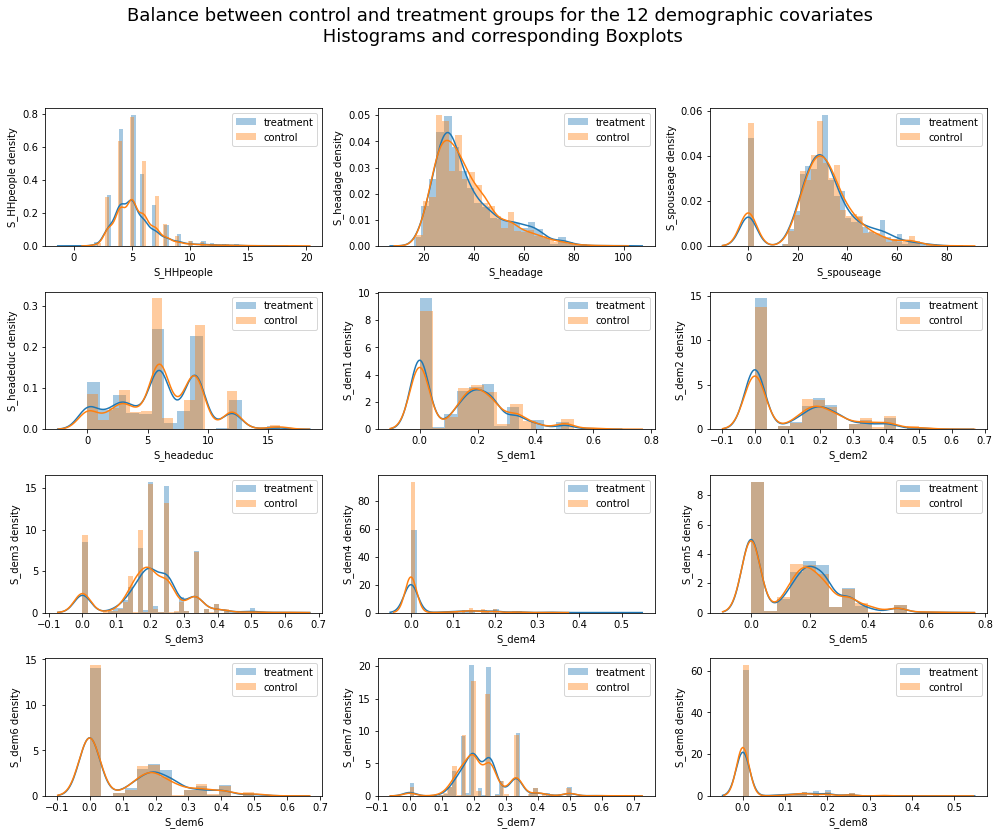

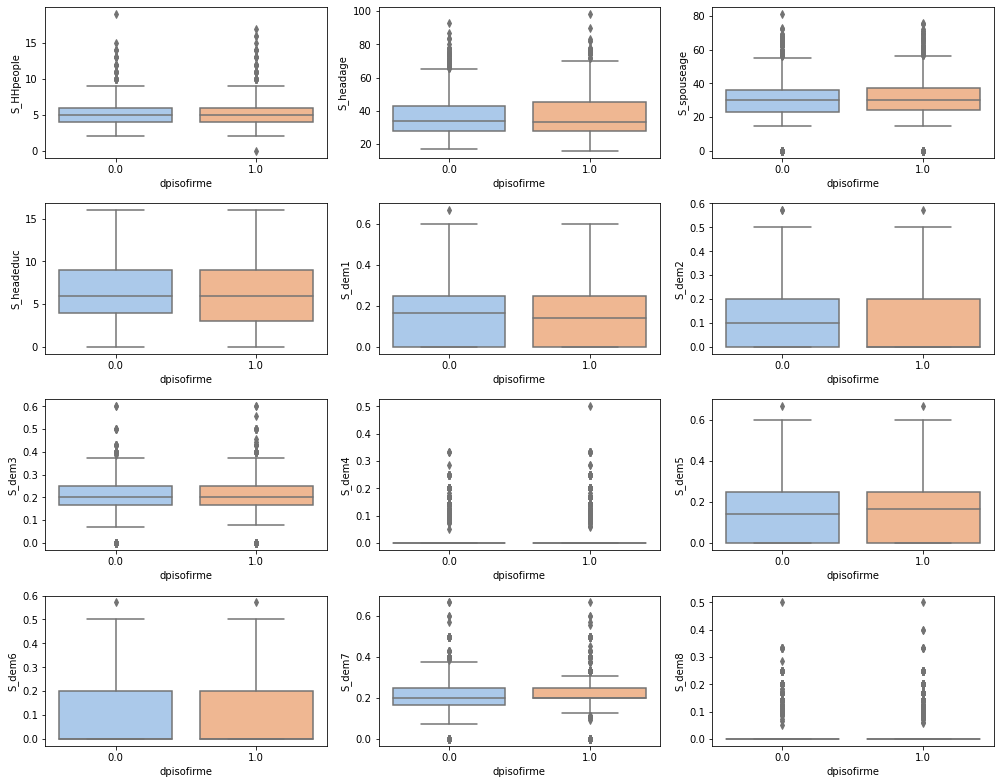

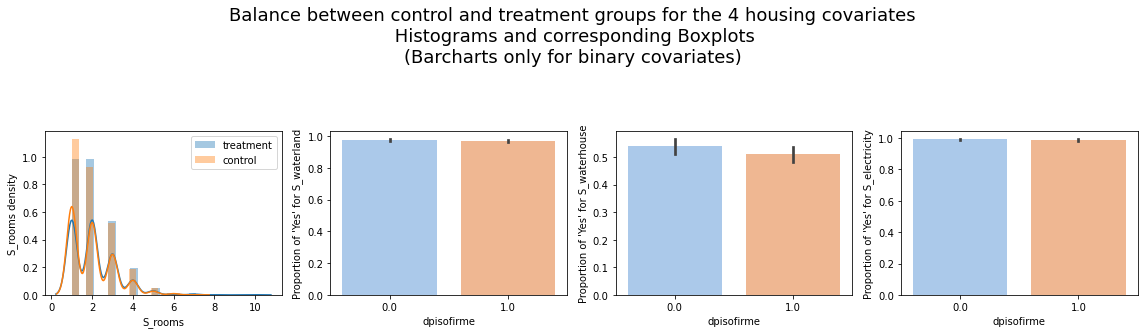

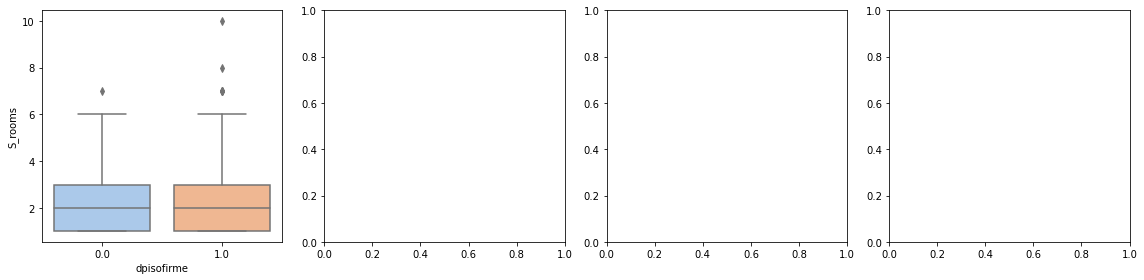

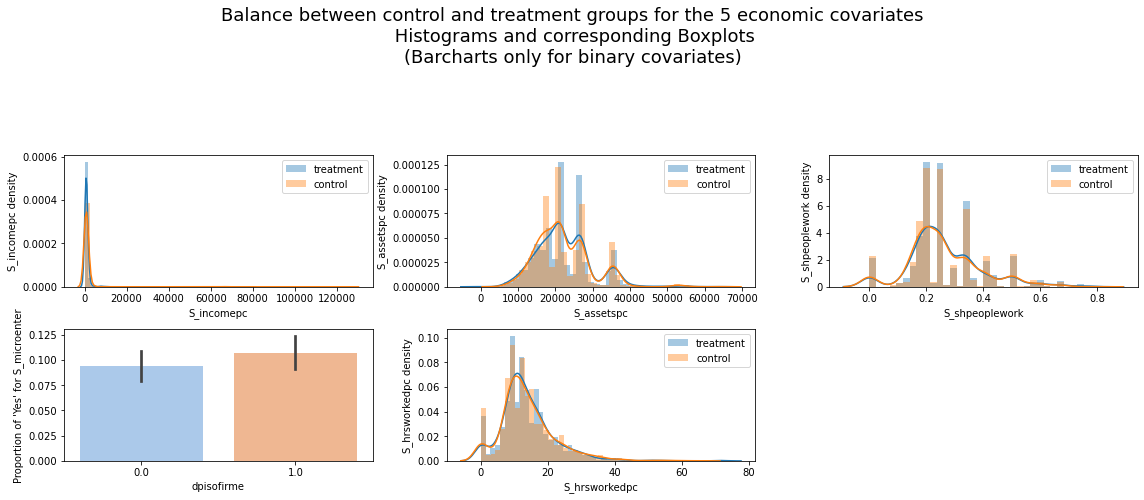

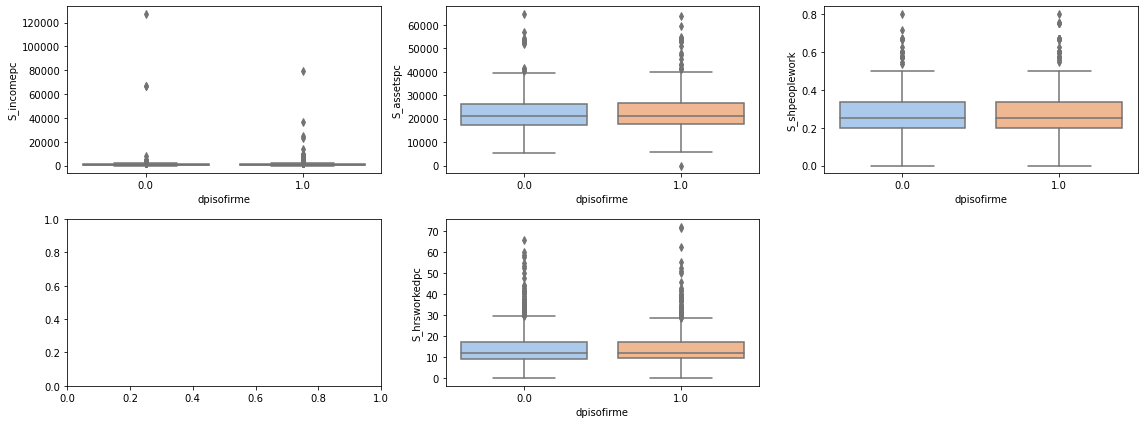

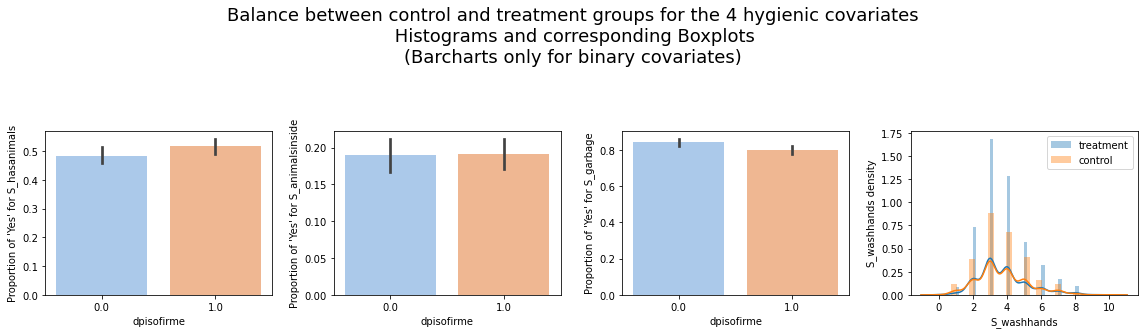

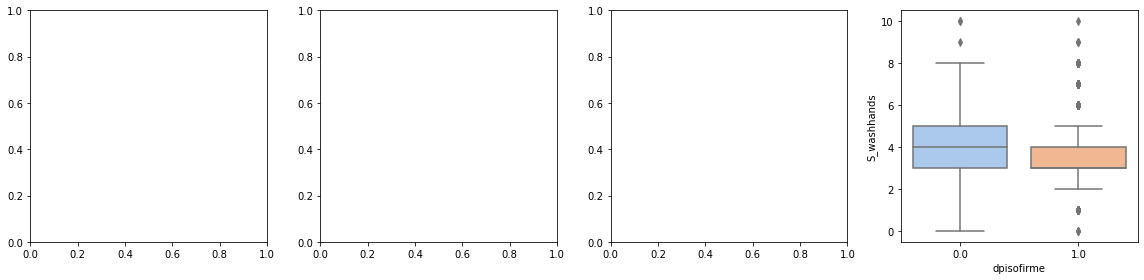

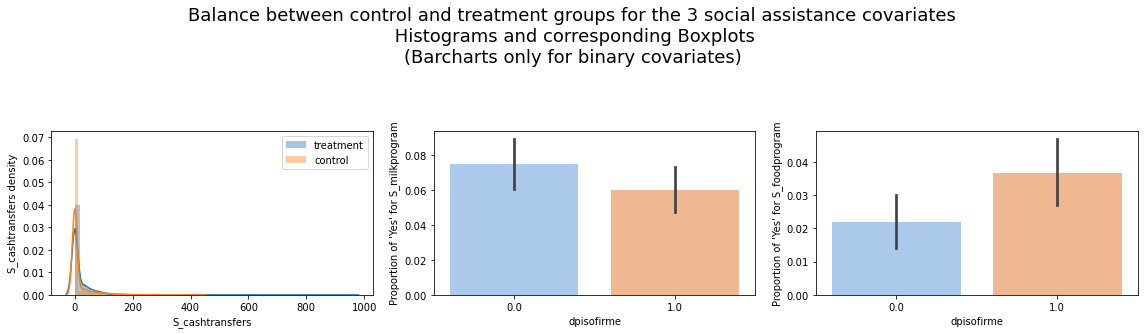

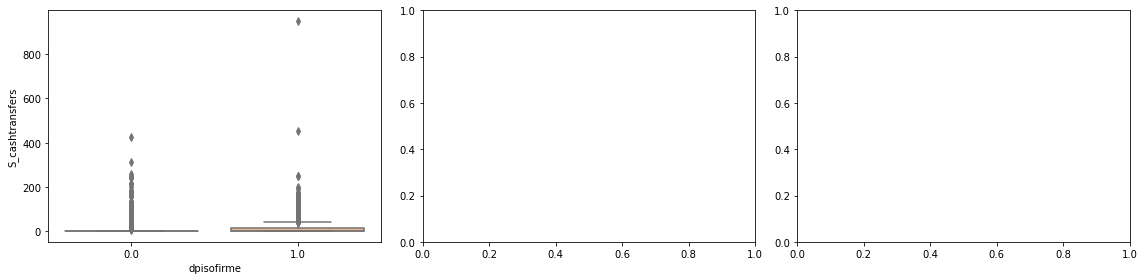

In [46]:
visualize_balance_all(treated_balanced_propensity, control_balanced_propensity, balanced_propensity)

<strong>c) re-evaluation of tables 4 and 6</strong>

In [11]:
final_results(balanced_propensity)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.727000,0.364,0.203,0.020,27.866,5.412469e-24,0.204,0.018,27.989,6.241686e-29,0.206,0.018,28.286,5.920793e-30
Cement floor in kitchen,0.670000,0.471,0.256,0.024,38.176,8.850812e-27,0.256,0.021,38.104,1.352627e-33,0.260,0.022,38.748,3.153589e-33
Cement floor in dining room,0.707000,0.455,0.211,0.025,29.843,1.107672e-17,0.213,0.024,30.029,1.784903e-19,0.217,0.024,30.557,7.012908e-20
Cement floor in bathroom,0.802000,0.399,0.106,0.022,13.173,1.132100e-06,0.109,0.018,13.603,8.994888e-10,0.112,0.018,14.012,1.794060e-10
Cement floor in bedroom,0.666000,0.472,0.239,0.020,35.852,3.850470e-32,0.244,0.020,36.527,5.349519e-34,0.243,0.019,36.470,5.583293e-36
Satisfaction with floor quality,0.510000,0.500,0.220,0.023,42.950,3.306490e-21,0.219,0.023,42.762,3.470775e-21,0.217,0.025,42.447,1.047681e-18
Satisfaction with house quality,0.608000,0.488,0.089,0.021,14.680,3.419701e-05,0.079,0.021,13.090,1.474696e-04,0.076,0.022,12.602,5.347697e-04
Satisfaction with quality of life,0.604000,0.489,0.109,0.022,18.207,5.757847e-07,0.103,0.020,17.215,3.386535e-07,0.104,0.021,17.332,9.084163e-07
Depression scale (CES-D scale),18.507999,9.478,-2.386,0.606,-12.922,8.310087e-05,-2.463,0.565,-13.339,1.311850e-05,-2.425,0.559,-13.131,1.456212e-05


<strong>d) Comparisons, discussion</strong>

<p>We can wee with the visualizations that the covariate balance is extremely similar to the original one, meaning that the propensity score matching method is not useful for improving the covariate balance. This is nevertheless not a big surprise, since the number of data points in the treatment group is the same as in the original treatment group (1362) and there are just 31 data points less in the control group as compared to the original control group (1362 instead of 1393).<br>
For the same reason, the results of tables 4 and 6 are also very similar to the results of the original tables.<p>

<h2 style="text-align:center" id="Propensity">2.2 Caliper matching methods</h2>


<h3 style="text-align:center" id="Propensity">2.2.1 Caliper matching with epsilon = 0.05</h3>


<strong>a) description</strong> 

<p>We now use the caliper matching method with epsilon = 0.05 to balance the samples. In this case, only pairs with similarity bigger than 0.95 are considered.</p> 

In [12]:
# Isolate the dataframe with matching propensity scores
balanced_caliper05 = matching(0.05)

# Extract balanced treated and control from matched dataframe
treated_balanced_caliper05 = balanced_caliper05[balanced_caliper05['dpisofirme']==1]
control_balanced_caliper05 = balanced_caliper05[balanced_caliper05['dpisofirme']==0]

# Display the length of treated and control households
len(treated_balanced_caliper05), len(control_balanced_caliper05)

(1349, 1349)

<strong>b) covariate balance visualization</strong>

<p>This matching created a treatment and control group of same size. <strong>1349</strong> datapoints for the <strong>treatment</strong> and <strong>1349</strong> for the <strong>control</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

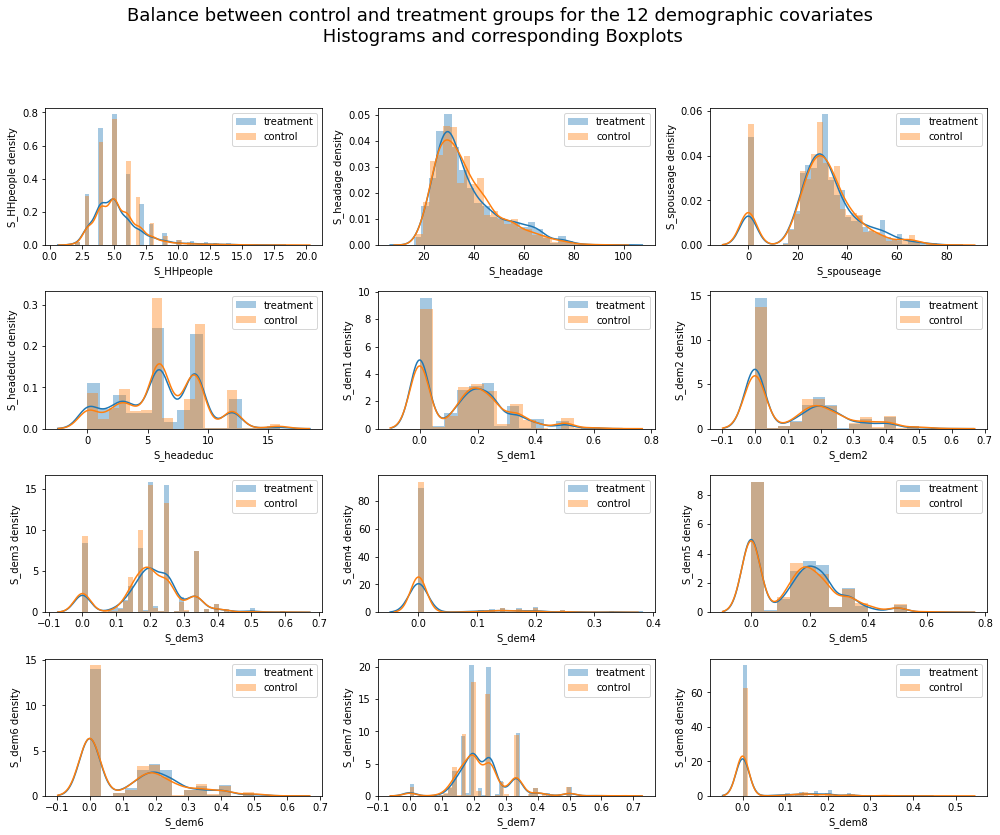

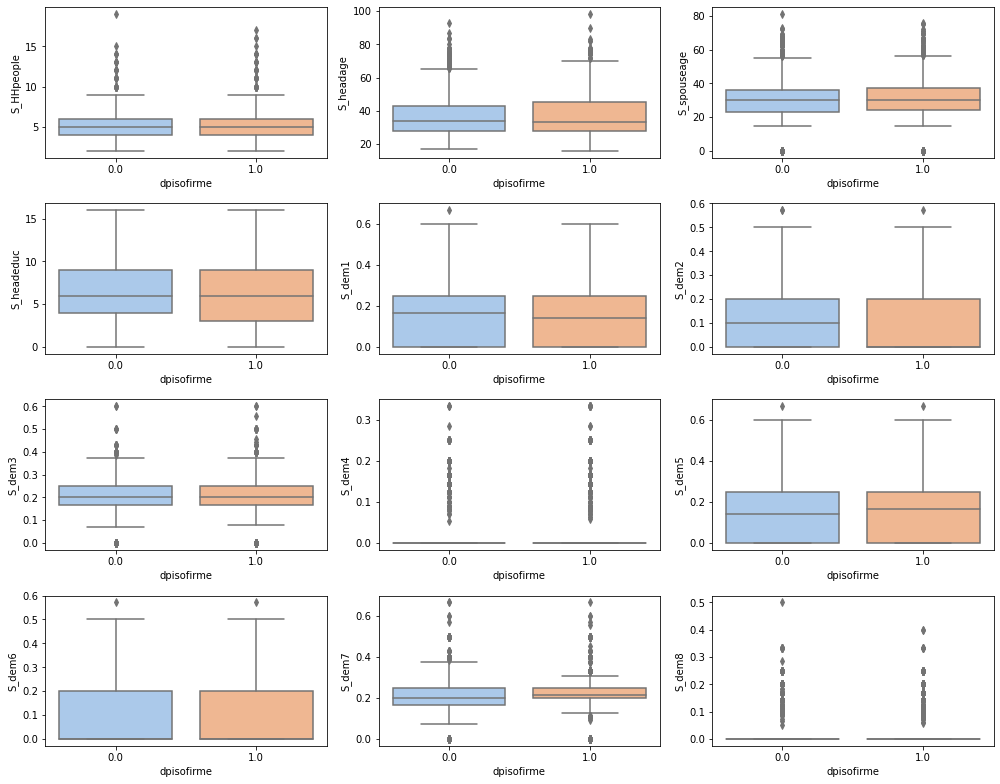

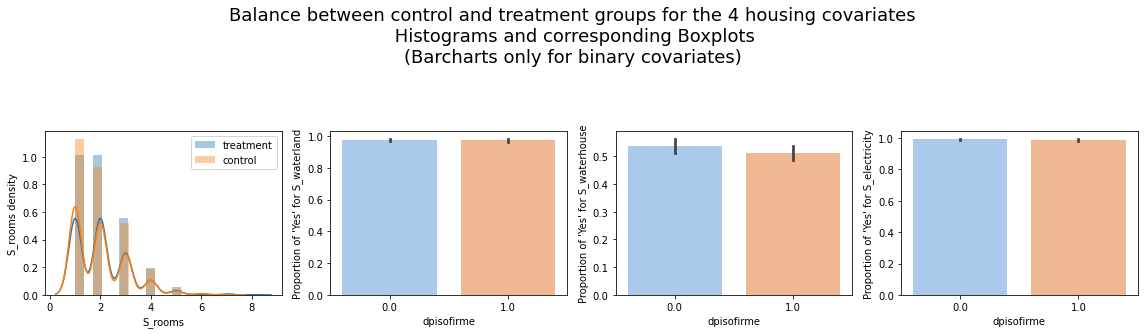

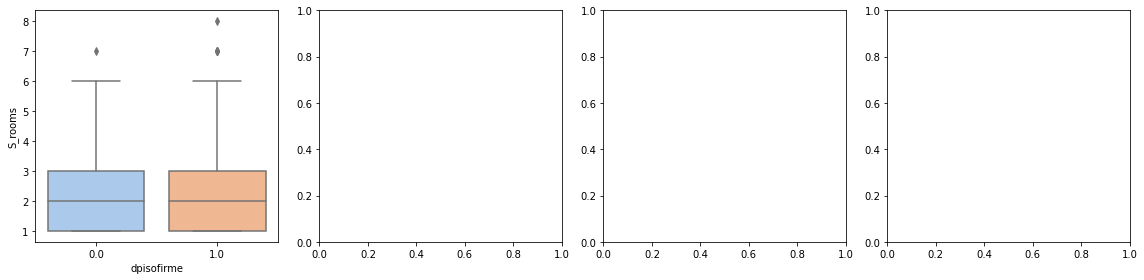

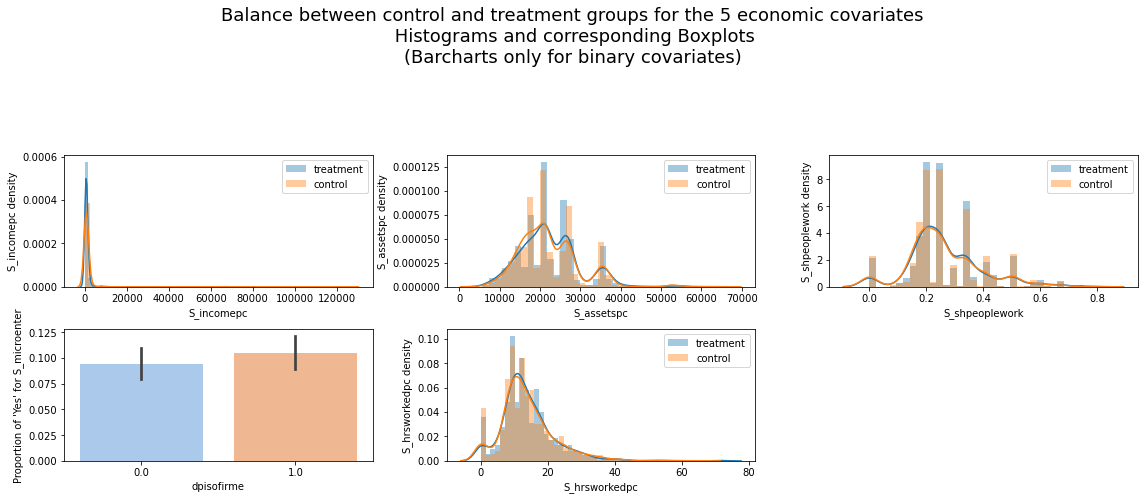

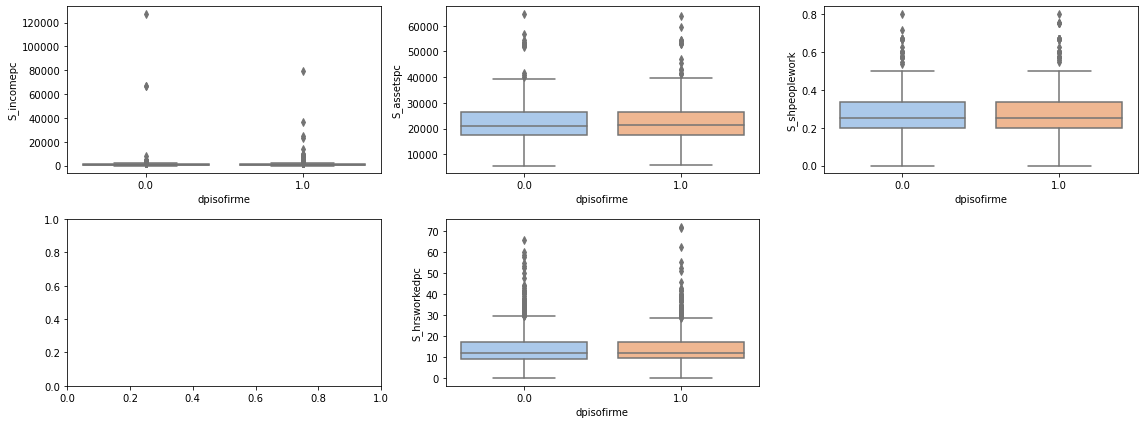

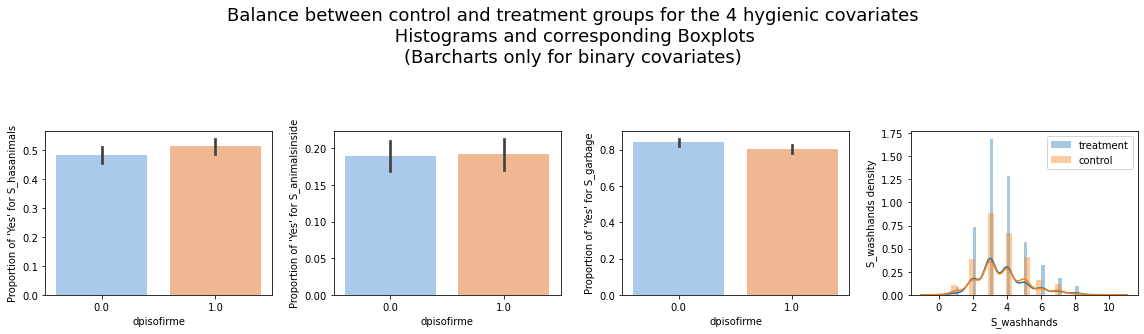

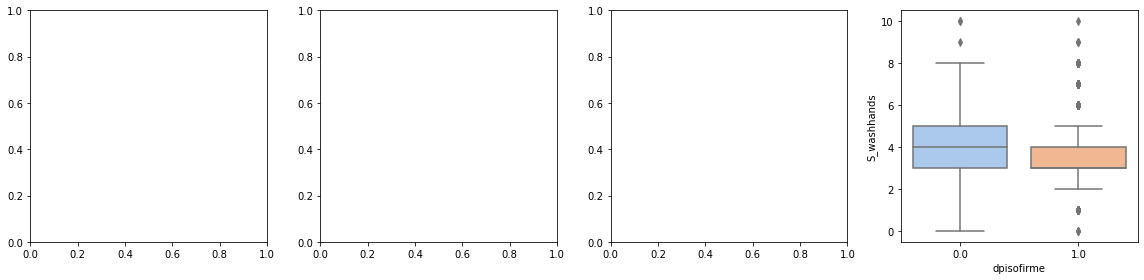

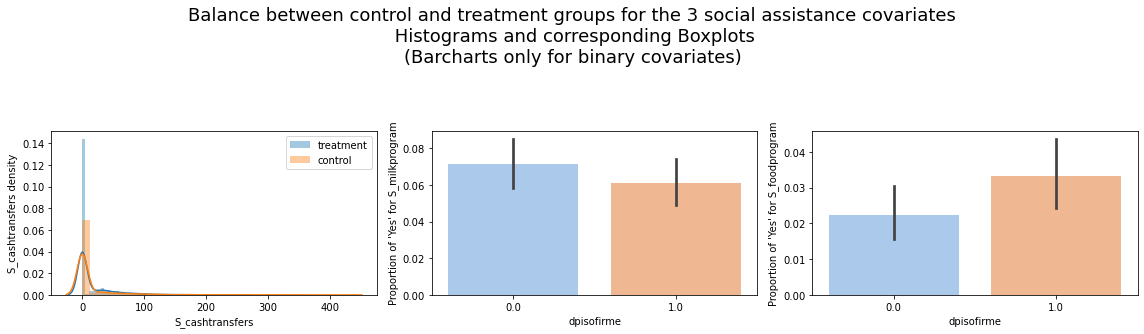

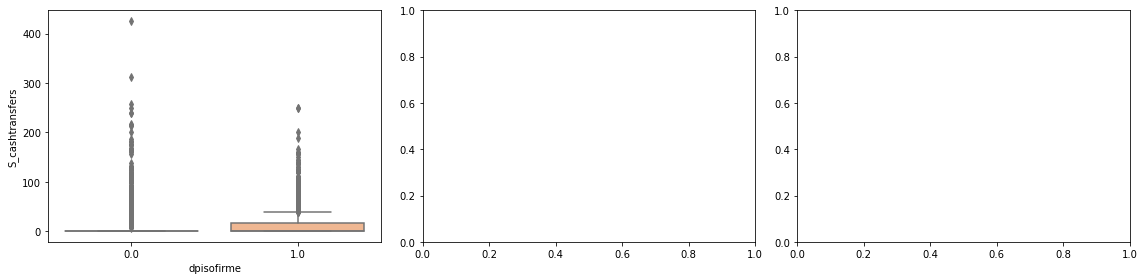

In [13]:
visualize_balance_all(treated_balanced_caliper05, control_balanced_caliper05, balanced_caliper05)

<strong>c) re-evaluation of tables 4 and 6</strong>

In [14]:
final_results(balanced_caliper05)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.727000,0.364,0.203,0.020,27.931,1.488046e-23,0.203,0.018,27.916,4.031570e-28,0.205,0.018,28.225,1.164430e-28
Cement floor in kitchen,0.669000,0.471,0.258,0.024,38.433,1.928563e-26,0.256,0.022,38.124,2.471393e-32,0.259,0.022,38.661,9.219531e-32
Cement floor in dining room,0.707000,0.455,0.211,0.025,29.817,2.893645e-17,0.212,0.024,29.891,7.413501e-19,0.216,0.024,30.424,2.400528e-19
Cement floor in bathroom,0.801000,0.399,0.107,0.022,13.393,6.327803e-07,0.109,0.018,13.610,1.028031e-09,0.113,0.018,14.122,1.052682e-10
Cement floor in bedroom,0.666000,0.472,0.239,0.021,35.753,1.316187e-30,0.242,0.020,36.225,5.862528e-33,0.242,0.020,36.189,1.430956e-34
Satisfaction with floor quality,0.510000,0.500,0.220,0.024,43.074,2.243566e-20,0.220,0.024,42.987,1.098099e-20,0.218,0.025,42.721,1.693102e-18
Satisfaction with house quality,0.606000,0.489,0.090,0.022,14.822,4.933213e-05,0.081,0.021,13.420,1.152153e-04,0.079,0.022,13.033,3.659636e-04
Satisfaction with quality of life,0.601000,0.490,0.111,0.022,18.506,7.464378e-07,0.106,0.021,17.721,2.130646e-07,0.107,0.021,17.866,4.566561e-07
Depression scale (CES-D scale),18.459999,9.461,-2.397,0.618,-12.982,1.049766e-04,-2.446,0.563,-13.244,1.397346e-05,-2.415,0.566,-13.079,1.970598e-05


<strong>d) Comparisons, discussion</strong>

<p>The balance of the covariates is still extremely similar to the original balance. This matching does not improve the balance considerably. Consequently, all the results of tables 4 and 6 remain very similar. The results are all statistically significant at 1 percent level with very small p-values.</p>

<h3 style="text-align:center" id="Propensity">2.2.2 Caliper matching with epsilon = 0.01</h3>


<strong>a) description</strong>

<p>We now try the caliper matching method with epsilon = 0.01 to balance the samples. Thus, only pairs with similarity bigger than 0.99 will be considered.</p> 

In [15]:
# Isolate the dataframe with matching propensity scores
balanced_caliper01 = matching(0.01)

# Extract balanced treated and control from matched dataframe
treated_balanced_caliper01 = balanced_caliper01[balanced_caliper01['dpisofirme']==1]
control_balanced_caliper01 = balanced_caliper01[balanced_caliper01['dpisofirme']==0]

# Display the length of treated and control households
len(treated_balanced_caliper01), len(control_balanced_caliper01)

(1191, 1191)

<strong>b) covariate balance visualization</strong>

<p>This matching created a treatment and control group of same size. <strong>1191</strong> datapoints for the <strong>treatment</strong> and <strong>1191</strong> for the <strong>control</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

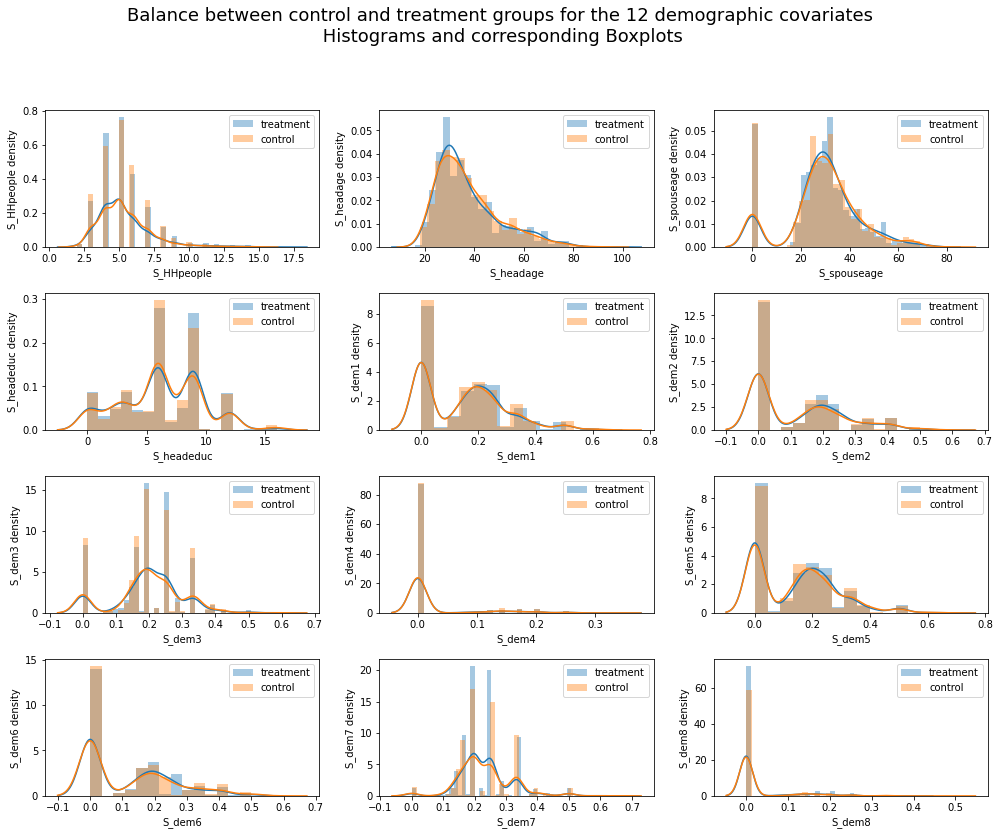

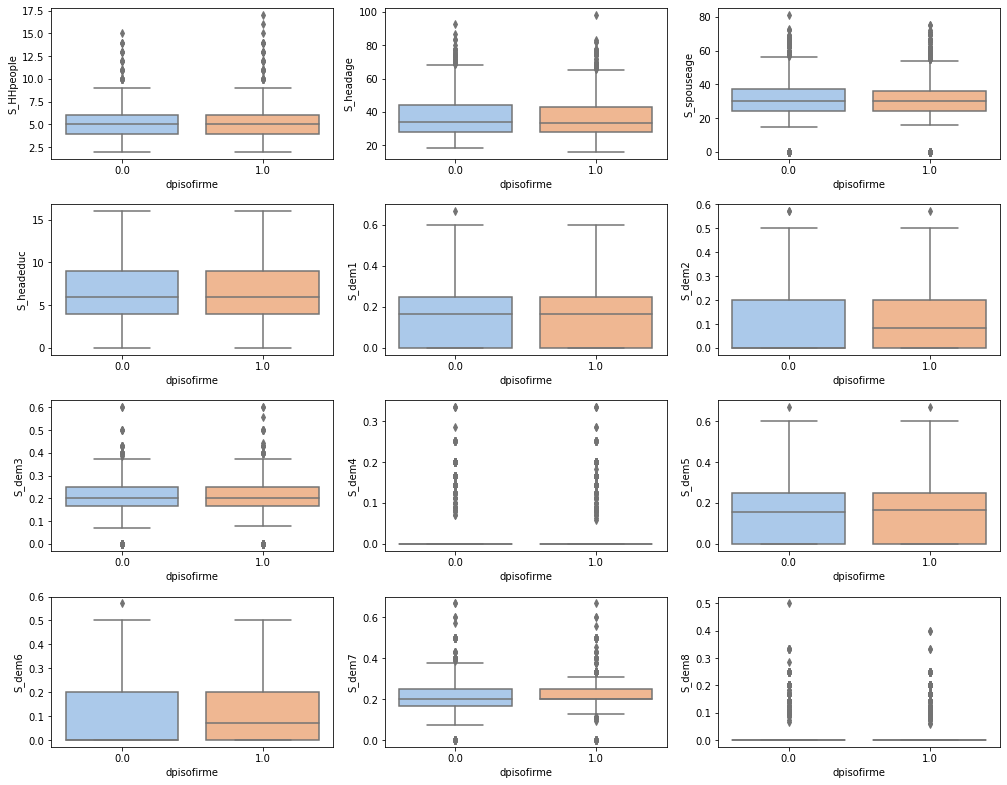

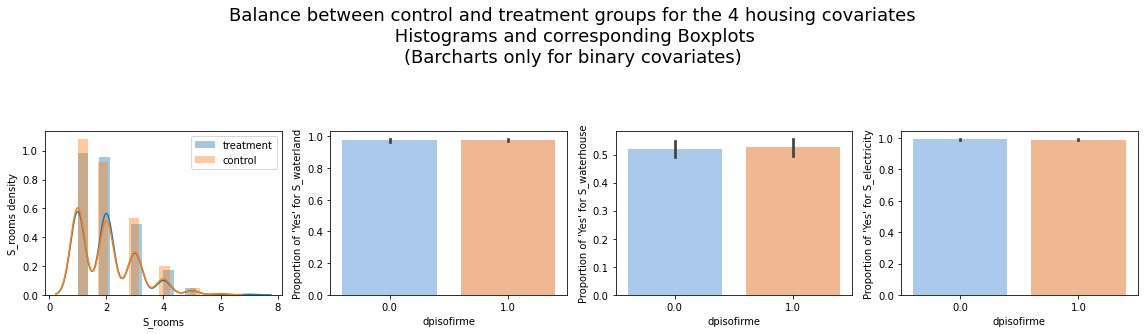

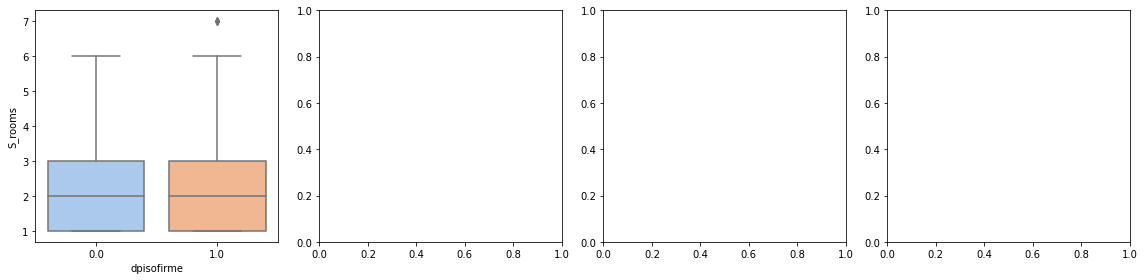

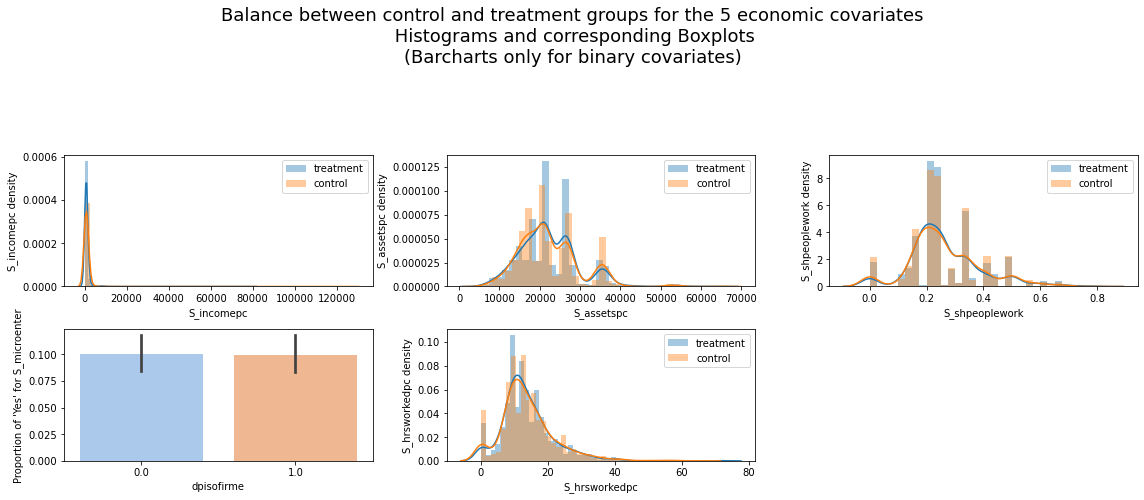

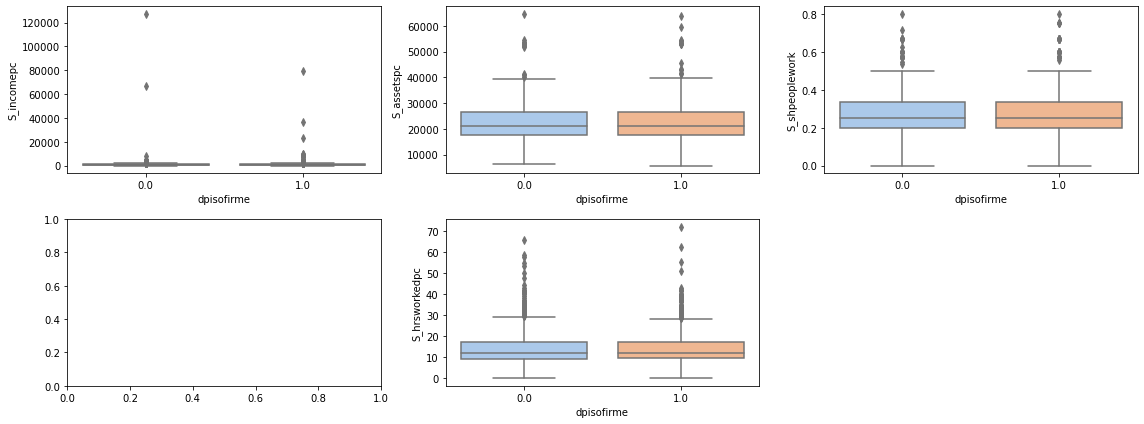

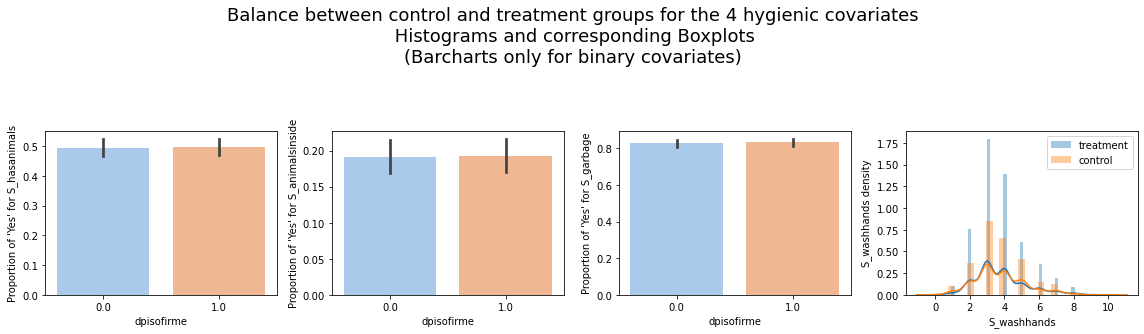

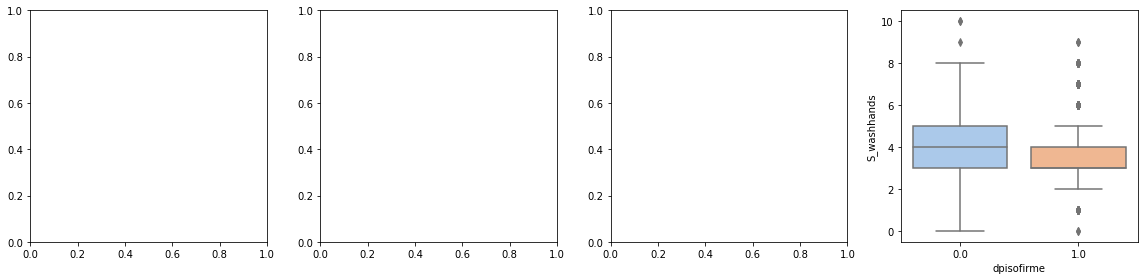

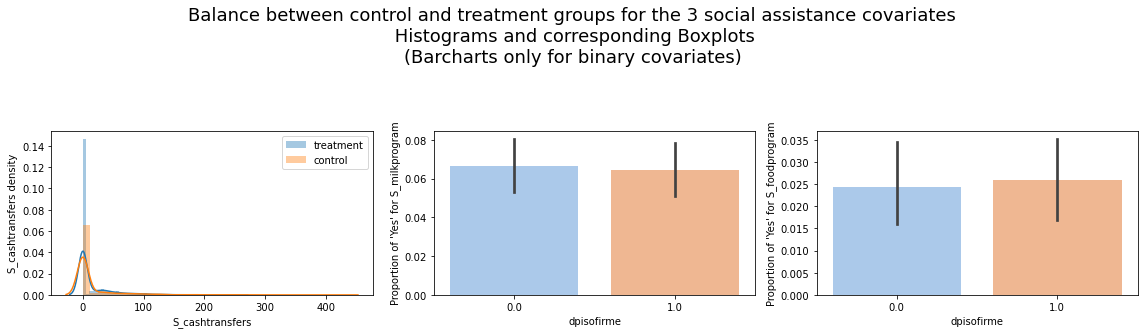

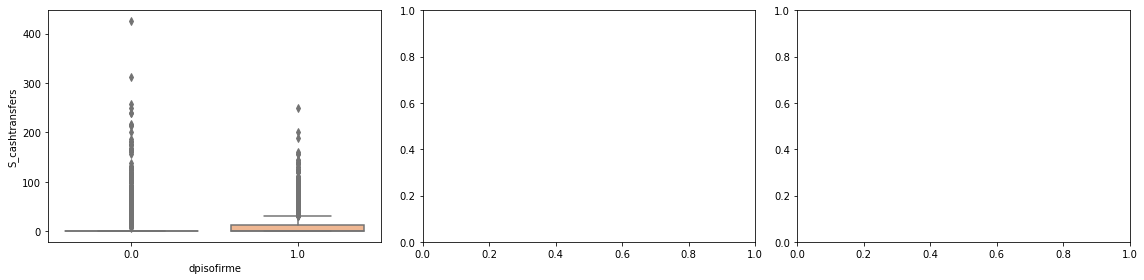

In [16]:
visualize_balance_all(treated_balanced_caliper01, control_balanced_caliper01, balanced_caliper01)

<strong>c) re-evaluation of tables 4 and 6</strong>

In [17]:
final_results(balanced_caliper01)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.725000,0.365,0.209,0.022,28.709,9.864511e-22,0.208,0.020,28.535,2.474988e-26,0.208,0.019,28.617,6.941921e-28
Cement floor in kitchen,0.669000,0.471,0.259,0.026,38.653,2.872542e-24,0.258,0.023,38.407,3.293528e-30,0.260,0.023,38.681,1.116659e-30
Cement floor in dining room,0.704000,0.457,0.221,0.027,31.166,3.846942e-16,0.220,0.025,31.060,3.344688e-18,0.221,0.025,31.239,7.215033e-19
Cement floor in bathroom,0.801000,0.399,0.114,0.022,14.228,1.672255e-07,0.113,0.017,14.039,7.732536e-11,0.115,0.017,14.357,3.926218e-11
Cement floor in bedroom,0.662000,0.473,0.243,0.023,36.472,1.269681e-25,0.242,0.022,36.227,5.910905e-28,0.241,0.021,36.127,5.233188e-30
Satisfaction with floor quality,0.503000,0.500,0.222,0.025,43.367,6.674334e-19,0.223,0.025,43.536,1.792386e-19,0.223,0.025,43.593,1.209697e-18
Satisfaction with house quality,0.612000,0.487,0.081,0.021,13.458,1.401860e-04,0.081,0.020,13.457,3.940807e-05,0.082,0.020,13.532,5.779714e-05
Satisfaction with quality of life,0.599000,0.490,0.111,0.024,18.445,2.793206e-06,0.111,0.022,18.523,2.748794e-07,0.112,0.022,18.711,4.526159e-07
Depression scale (CES-D scale),18.499001,9.464,-2.581,0.621,-13.977,3.265436e-05,-2.569,0.570,-13.911,6.500278e-06,-2.537,0.566,-13.739,7.463684e-06


<strong>d) Comparisons, discussion</strong>

<p>We can see that the balance slightly improved for all the covariates, notably the covariates S_headeduc (Head of household's years of schooling), S_hasanimals (Household has animals on land), S_garbage(Uses garbage collection service) and S_milkprogram (Household beneficiary of government milk supplement program) as can be seen in <i>Note 1</i>. However, this improved balance does not change the statistical significance of the results. Indeed, tables 4 and 6 are still very close to the original tables with p-values that remain very small. <br>  

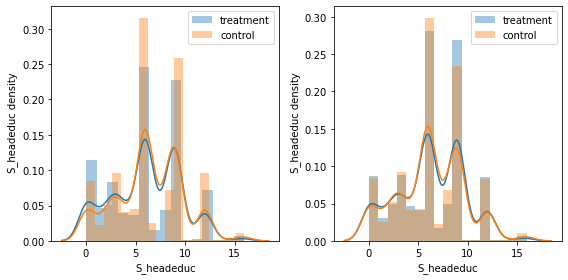

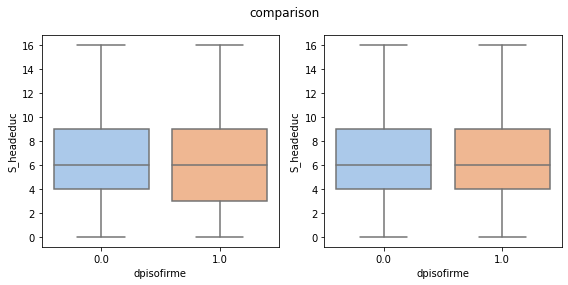

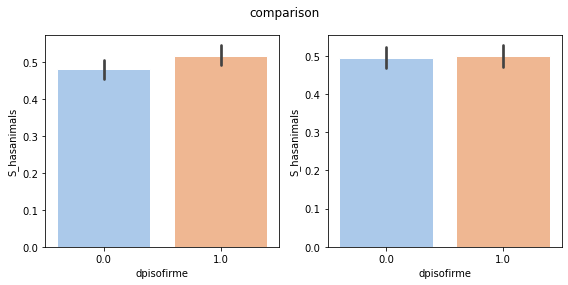

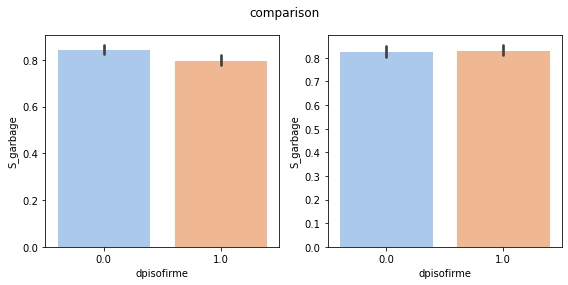

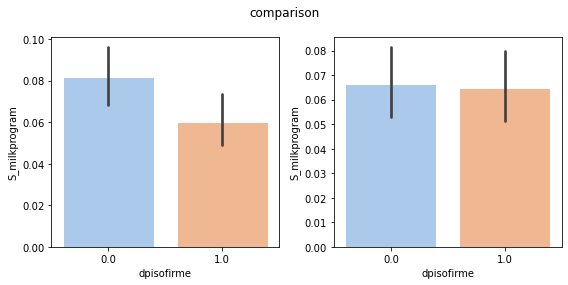

In [44]:
print("Note 1:")
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.distplot(treated["S_headeduc"].dropna(), ax=axes[0], label="treatment")
sns.distplot(control["S_headeduc"].dropna(), ax=axes[0], label="control")
axes[0].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[0].legend()
sns.distplot(treated_balanced_caliper01["S_headeduc"].dropna(), ax=axes[1], label="treatment")
sns.distplot(control_balanced_caliper01["S_headeduc"].dropna(), ax=axes[1], label="control")
axes[1].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[1].legend()
fig.tight_layout()

figa, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=household_data, x="dpisofirme", y="S_headeduc", ax = axes[0], palette="pastel")
    sns.boxplot(data=balanced_caliper01, x="dpisofirme", y="S_headeduc", ax = axes[1], palette="pastel")
figa.suptitle("comparison")
figa.tight_layout()
    
figb, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_hasanimals", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper01, x="dpisofirme", y="S_hasanimals", ax = axes[1], palette="pastel")
figb.suptitle("comparison")
figb.tight_layout()
    
    
figc, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_garbage", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper01, x="dpisofirme", y="S_garbage", ax = axes[1], palette="pastel")
figc.suptitle("comparison")
figc.tight_layout() 

figd, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_milkprogram", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper01, x="dpisofirme", y="S_milkprogram", ax = axes[1], palette="pastel")
figd.suptitle("comparison")
figd.tight_layout()

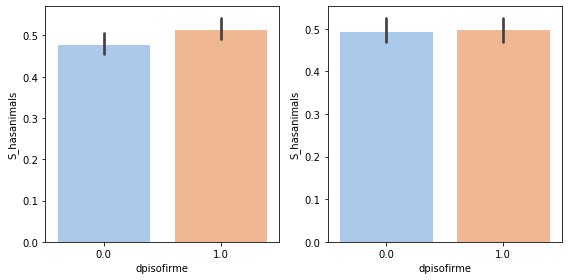

In [64]:
figb, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_hasanimals", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper01, x="dpisofirme", y="S_hasanimals", ax = axes[1], palette="pastel")
#figb.suptitle("comparison")
figb.tight_layout()
plt.savefig('figures/hasanimals_mean.png')

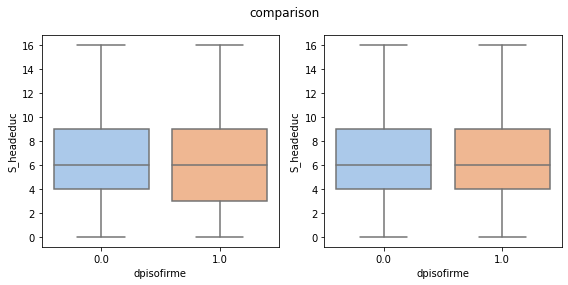

In [41]:
figa, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=household_data, x="dpisofirme", y="S_headeduc", ax = axes[0], palette="pastel")
    sns.boxplot(data=balanced_caliper01, x="dpisofirme", y="S_headeduc", ax = axes[1], palette="pastel")
figa.suptitle("comparison")
figa.tight_layout()
plt.savefig('figures/dpi.png')
fig.tight_layout()
plt.savefig('figures/headeduc_boxplot.png')

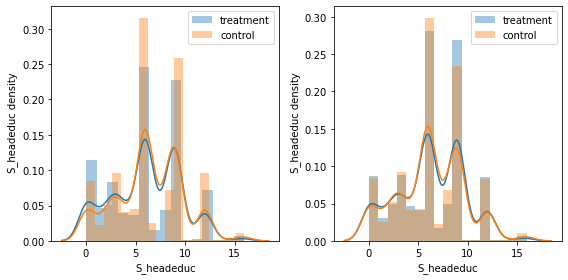

In [42]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.distplot(treated["S_headeduc"].dropna(), ax=axes[0], label="treatment")
sns.distplot(control["S_headeduc"].dropna(), ax=axes[0], label="control")
axes[0].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[0].legend()
sns.distplot(treated_balanced_caliper01["S_headeduc"].dropna(), ax=axes[1], label="treatment")
sns.distplot(control_balanced_caliper01["S_headeduc"].dropna(), ax=axes[1], label="control")
axes[1].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[1].legend()
fig.tight_layout()
plt.savefig('figures/headeduc_hist.png')

<h3 style="text-align:center" id="Propensity">2.2.3 Caliper matching with epsilon = 0.001</h3>


<strong>a) description</strong>

<p>We next use of the caliper matching method with an even smaller epsilon = 0.001 to balance the samples. Thus, only pairs with similarity bigger than 0.999 will be considered.</p>

In [22]:
# Isolate the dataframe with matching propensity scores
balanced_caliper001 = matching(0.001)

# Extract balanced treated and control from matched dataframe
treated_balanced_caliper001 = balanced_caliper001[balanced_caliper001['dpisofirme']==1]
control_balanced_caliper001 = balanced_caliper001[balanced_caliper001['dpisofirme']==0]

# Display the length of treated and control households
len(treated_balanced_caliper001), len(control_balanced_caliper001)

(1103, 1103)

<strong>b) covariate balance visualization</strong>

<p>This matching created a treatment and control group of same size. <strong>1103</strong> datapoints for the <strong>treatment</strong> and <strong>1103</strong> for the <strong>control</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

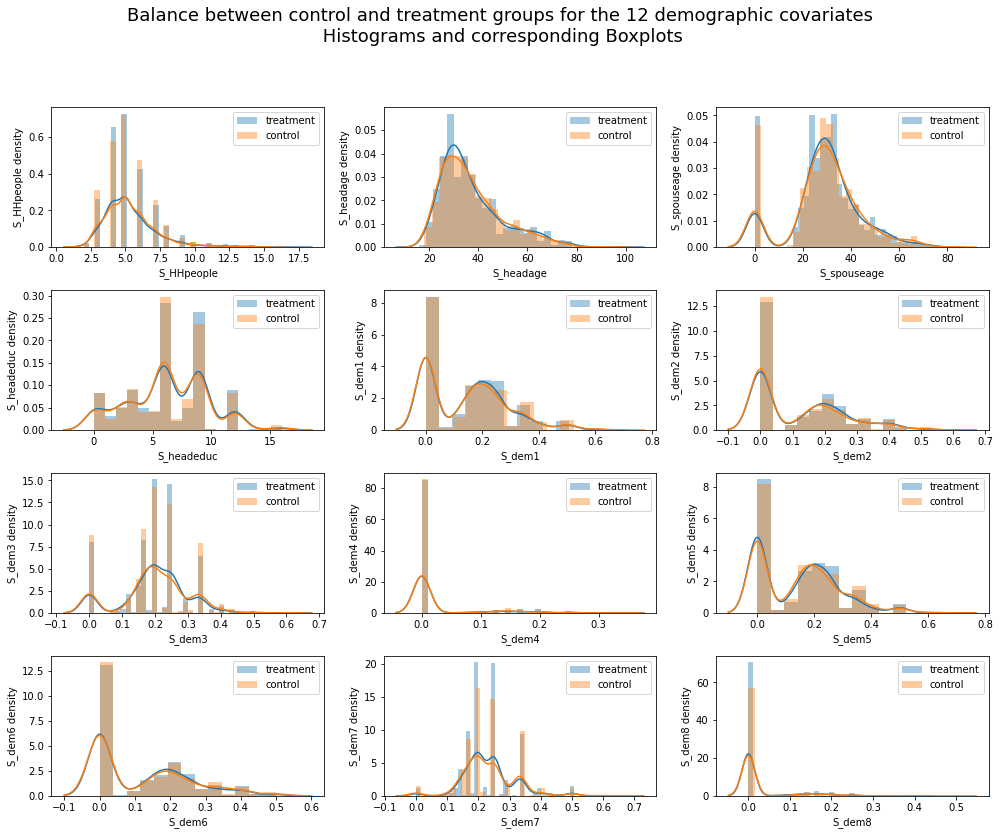

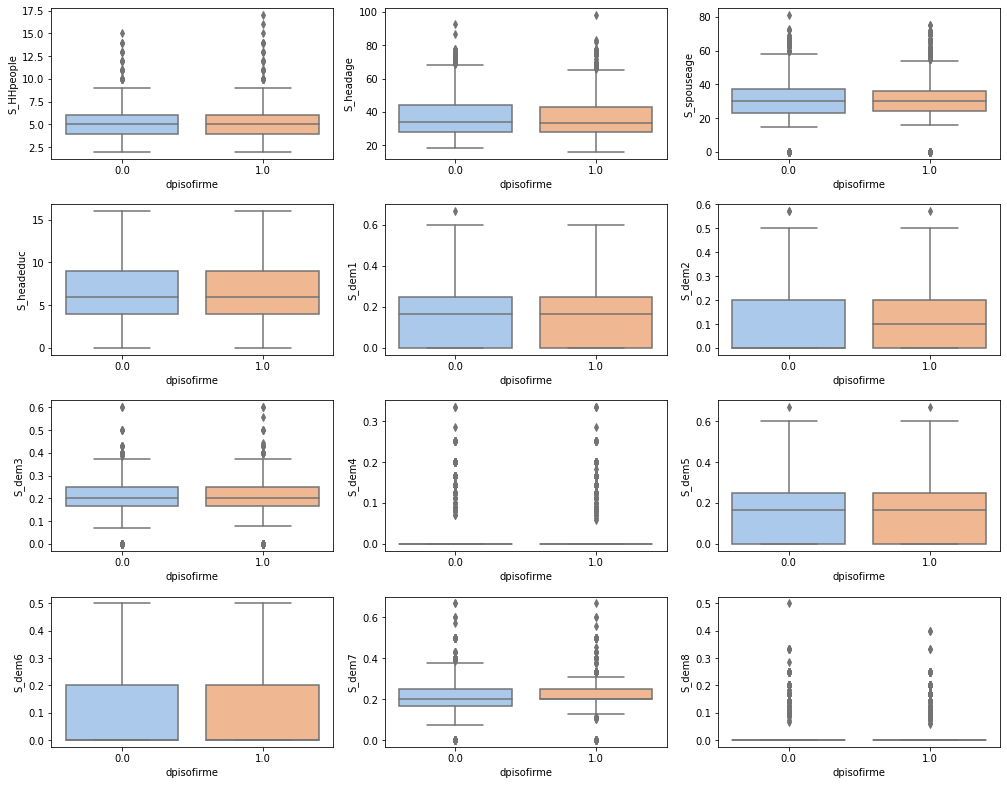

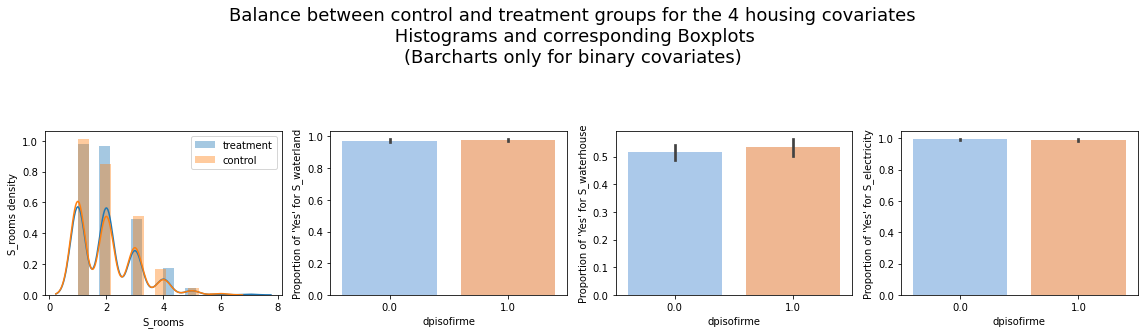

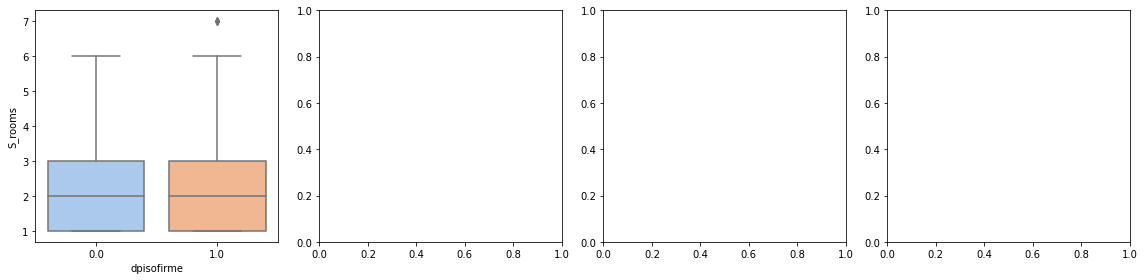

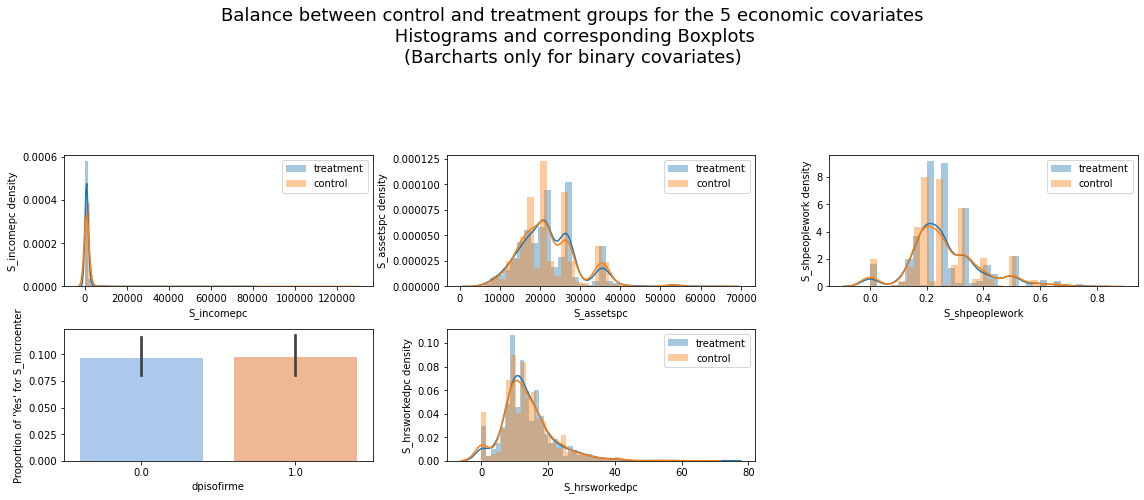

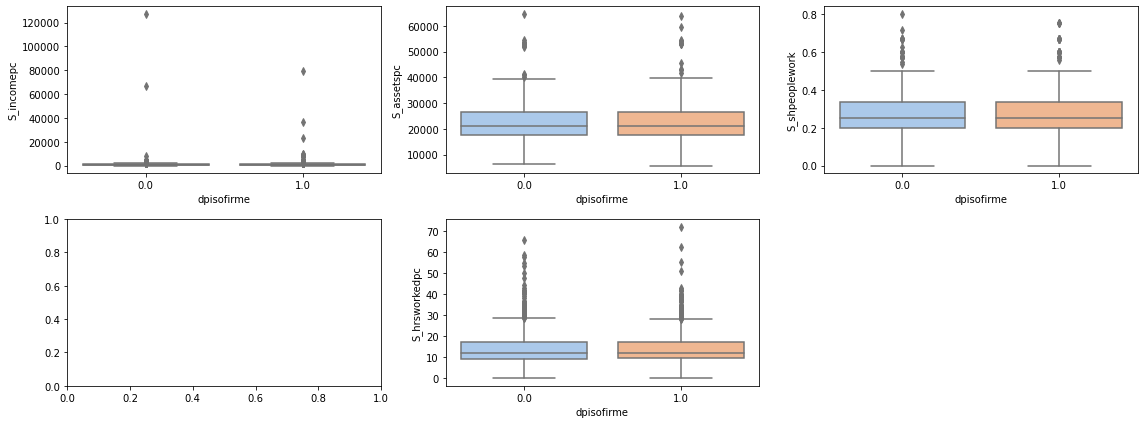

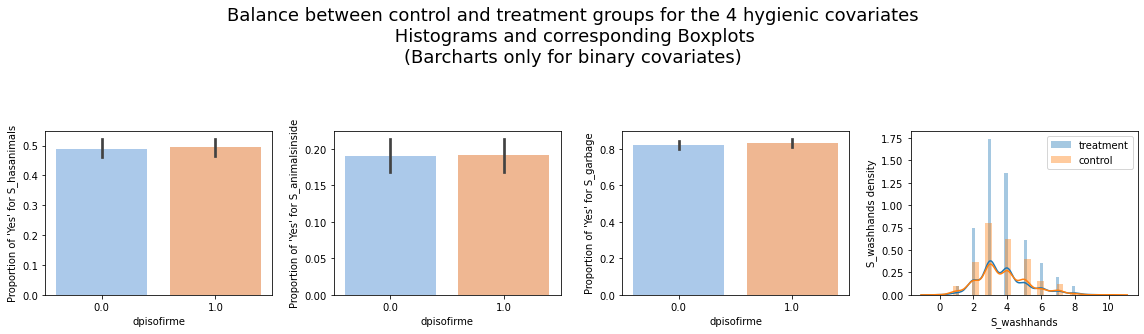

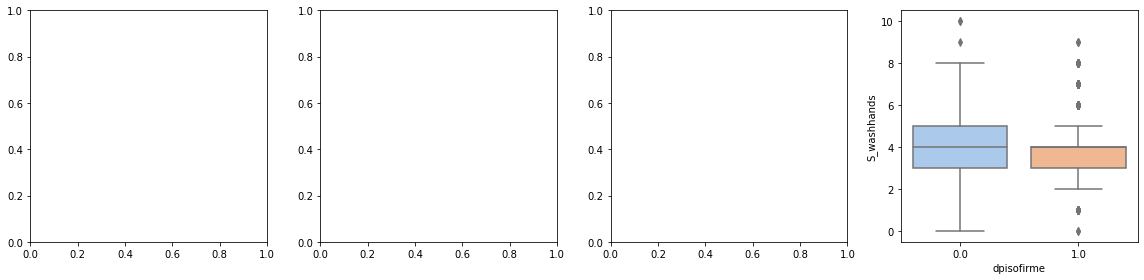

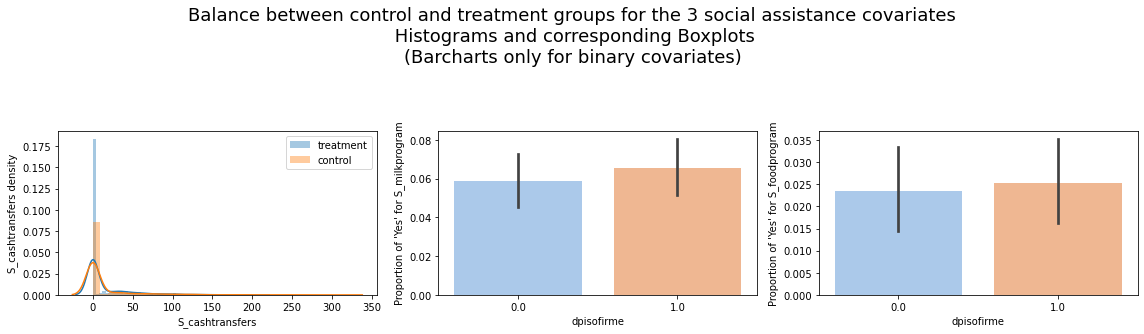

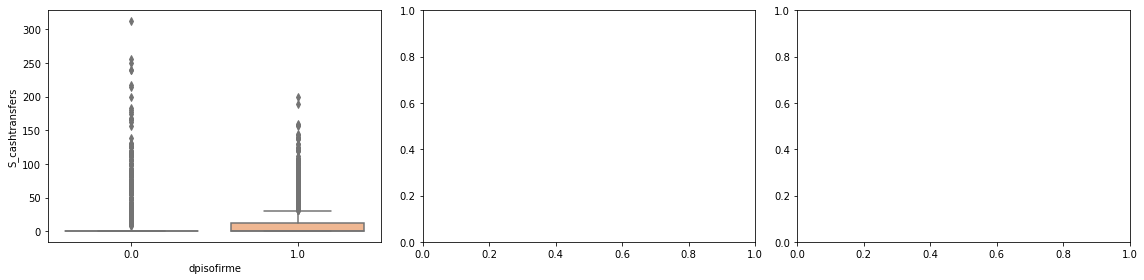

In [23]:
visualize_balance_all(treated_balanced_caliper001, control_balanced_caliper001, balanced_caliper001)

<strong>c) re-evaluation of tables 4 and 6</strong>

In [24]:
final_results(balanced_caliper001)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.722000,0.368,0.211,0.021,29.059,4.807399e-23,0.208,0.019,28.547,1.086246e-27,0.209,0.019,28.674,5.441560e-29
Cement floor in kitchen,0.668000,0.471,0.263,0.025,39.171,9.481329e-26,0.259,0.022,38.560,1.447710e-31,0.261,0.022,38.848,6.579069e-32
Cement floor in dining room,0.705000,0.456,0.219,0.027,30.965,4.117057e-16,0.216,0.025,30.517,3.895524e-18,0.218,0.025,30.712,2.065853e-18
Cement floor in bathroom,0.793000,0.405,0.121,0.022,15.024,7.356377e-08,0.116,0.018,14.473,4.196765e-11,0.119,0.018,14.807,2.550423e-11
Cement floor in bedroom,0.658000,0.475,0.248,0.023,37.073,1.542072e-26,0.244,0.022,36.486,4.630915e-29,0.244,0.021,36.492,3.540843e-31
Satisfaction with floor quality,0.505000,0.500,0.213,0.025,41.683,1.989638e-17,0.214,0.025,41.836,4.000919e-18,0.215,0.026,42.059,8.647972e-17
Satisfaction with house quality,0.613000,0.487,0.081,0.023,13.333,3.367413e-04,0.081,0.021,13.337,1.672833e-04,0.082,0.023,13.544,2.789431e-04
Satisfaction with quality of life,0.603000,0.490,0.107,0.023,17.805,3.694967e-06,0.107,0.022,17.849,7.953097e-07,0.109,0.022,18.164,1.109365e-06
Depression scale (CES-D scale),18.364000,9.395,-2.408,0.646,-13.040,1.952258e-04,-2.415,0.589,-13.078,4.184748e-05,-2.404,0.587,-13.020,4.242772e-05


<strong>d) Comparisons, discussion</strong>

<p> The balance for epsilon = 0.001 is extremely similar to the balance with epsilon = 0.01. The covariate S_dem1 (S_dem1: 2005 Survey - Proportion of Males 0-5yrs in household) is slightly more balanced with epsilon = 0.001 than epsilon = 0.01 as can be seen in <i>Note 2</i>. All the results of tables 4 and 6 are statistically significant as shown with the very small p-values.<br> 

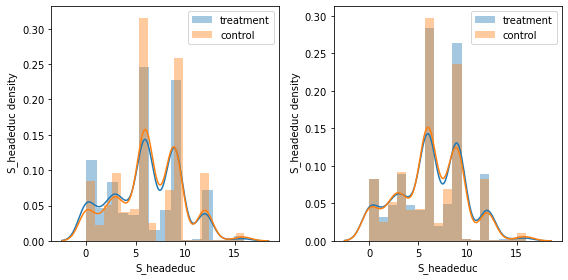

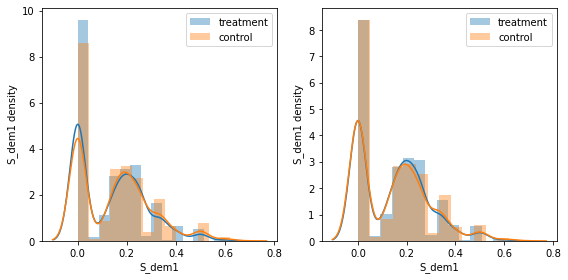

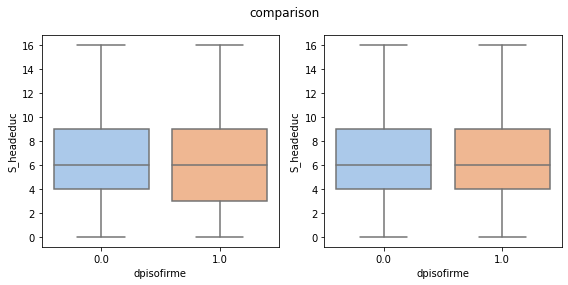

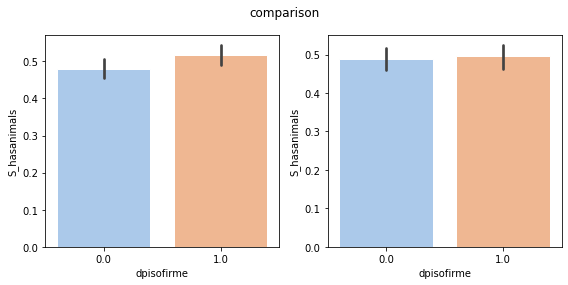

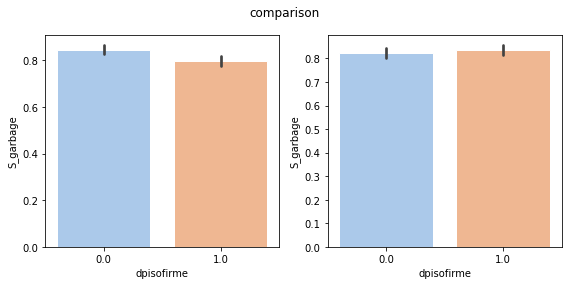

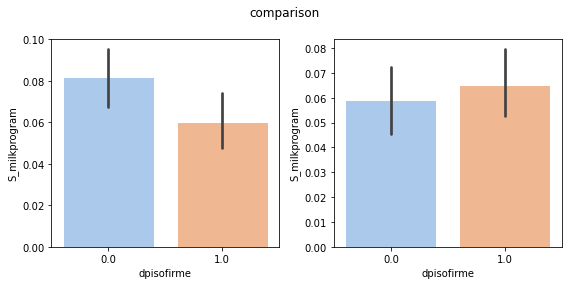

In [25]:
Print("Note 2:")
fig1, axes = plt.subplots(1,2, figsize=(8,4))
sns.distplot(treated["S_headeduc"].dropna(), ax=axes[0], label="treatment")
sns.distplot(control["S_headeduc"].dropna(), ax=axes[0], label="control")
axes[0].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[0].legend()
sns.distplot(treated_balanced_caliper001["S_headeduc"].dropna(), ax=axes[1], label="treatment")
sns.distplot(control_balanced_caliper001["S_headeduc"].dropna(), ax=axes[1], label="control")
axes[1].set(xlabel="S_headeduc", ylabel=" S_headeduc density")
axes[1].legend()
fig1.tight_layout()


fig2, axes = plt.subplots(1,2, figsize=(8,4))
sns.distplot(treated["S_dem1"].dropna(), ax=axes[0], label="treatment")
sns.distplot(control["S_dem1"].dropna(), ax=axes[0], label="control")
axes[0].set(xlabel="S_dem1", ylabel=" S_dem1 density")
axes[0].legend()
sns.distplot(treated_balanced_caliper001["S_dem1"].dropna(), ax=axes[1], label="treatment")
sns.distplot(control_balanced_caliper001["S_dem1"].dropna(), ax=axes[1], label="control")
axes[1].set(xlabel="S_dem1", ylabel=" S_dem1 density")
axes[1].legend()
fig2.tight_layout()


figa, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=household_data, x="dpisofirme", y="S_headeduc", ax = axes[0], palette="pastel")
    sns.boxplot(data=balanced_caliper001, x="dpisofirme", y="S_headeduc", ax = axes[1], palette="pastel")
figa.suptitle("comparison")
figa.tight_layout()


figb, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_hasanimals", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper001, x="dpisofirme", y="S_hasanimals", ax = axes[1], palette="pastel")
figb.suptitle("comparison")
figb.tight_layout()

    
figc, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_garbage", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper001, x="dpisofirme", y="S_garbage", ax = axes[1], palette="pastel")
figc.suptitle("comparison")
figc.tight_layout()


figd, axes = plt.subplots(1,2, figsize=(8,4))
with sns.axes_style("whitegrid"):
    sns.barplot(data=household_data, x="dpisofirme", y="S_milkprogram", ax = axes[0], palette="pastel")
    sns.barplot(data=balanced_caliper001, x="dpisofirme", y="S_milkprogram", ax = axes[1], palette="pastel")
figd.suptitle("comparison")
figd.tight_layout()

<h3 style="text-align:center" id="Propensity">2.2.4 Caliper matching with epsilon = 0.0001</h3>


<strong>a) description</strong>

<p>We finally try the caliper matching method with epsilon = 0.0001 to balance the samples. Thus, only pairs with similarity bigger than 0.9999 will be considered.</p> 

In [26]:
# Isolate the dataframe with matching propensity scores
balanced_caliper0001 = matching(0.0001)

# Extract balanced treated and control from matched dataframe
treated_balanced_caliper0001 = balanced_caliper0001[balanced_caliper0001['dpisofirme']==1]
control_balanced_caliper0001 = balanced_caliper0001[balanced_caliper0001['dpisofirme']==0]

# Display the length of treated and control households
len(treated_balanced_caliper0001), len(control_balanced_caliper0001)

(586, 586)

<strong>b) covariate balance visualization</strong>

<p>This matching created a treatment and control group of same size. <strong>586</strong> datapoints for the <strong>treatment</strong> and <strong>586</strong> for the <strong>control</strong>.<br>Discrete and continuous covariates are visualized with histograms and boxplots. Binary covariates are visualized with barplots only. In the following figure, the boxplots corresponding to binary covariates are empty, since boxplots make no sense for binary variables.</p>

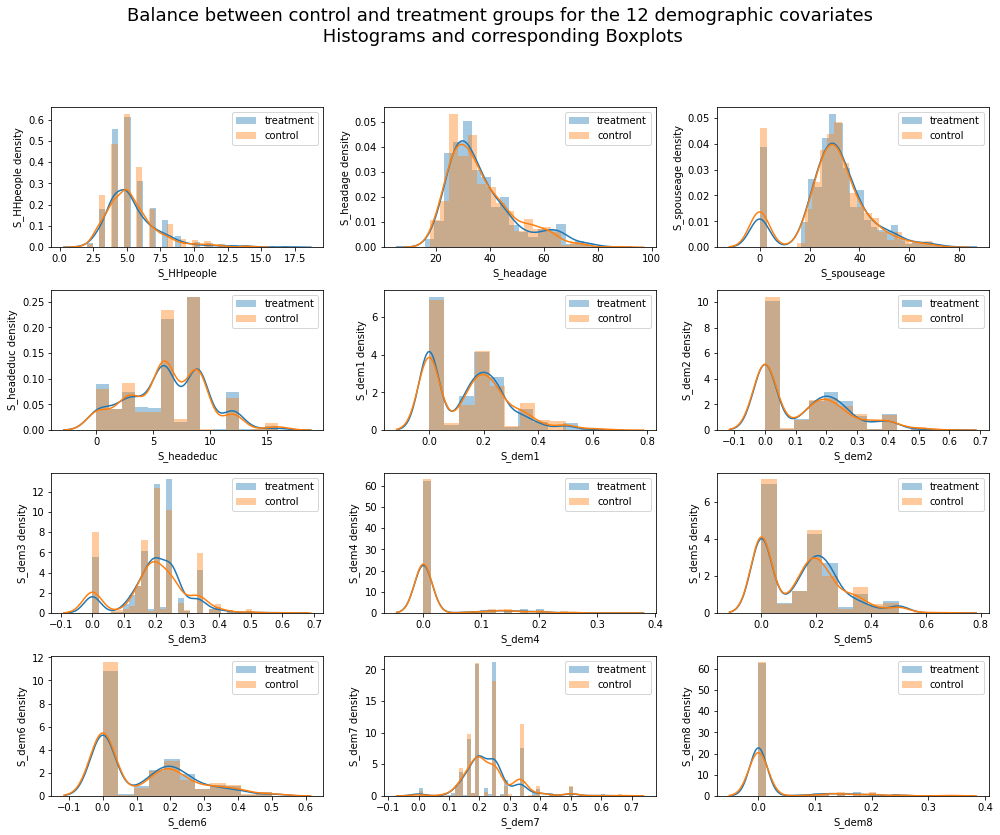

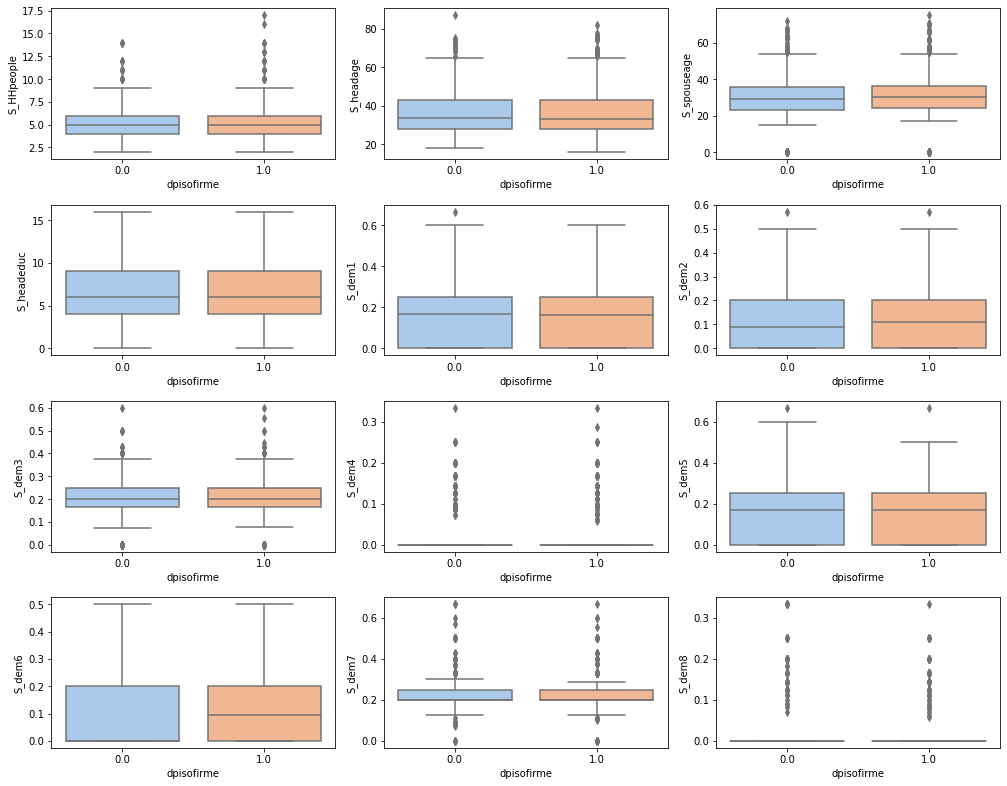

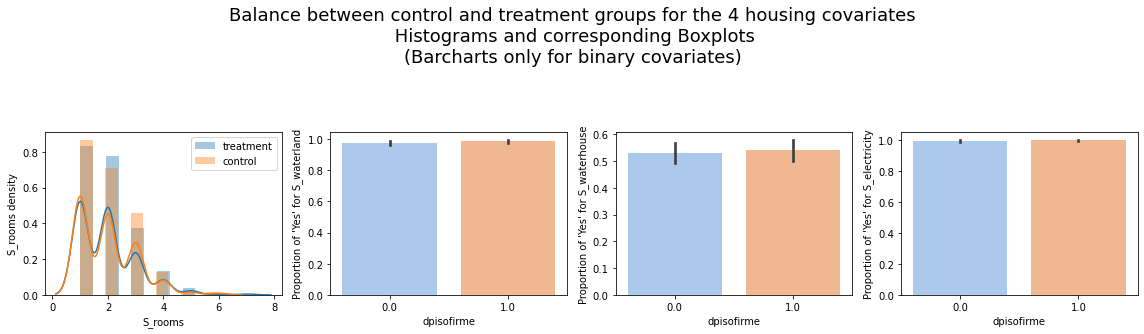

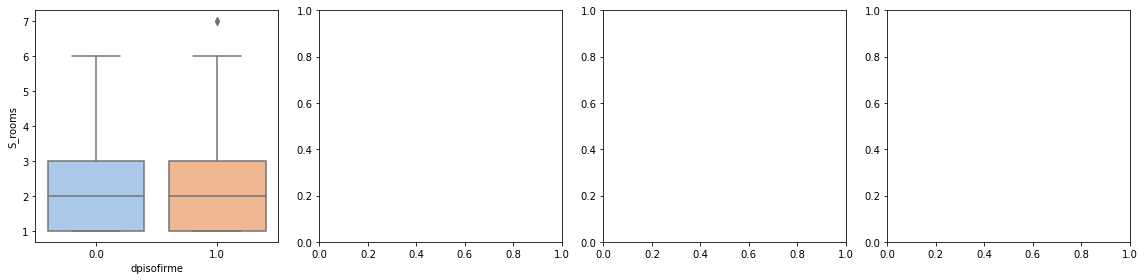

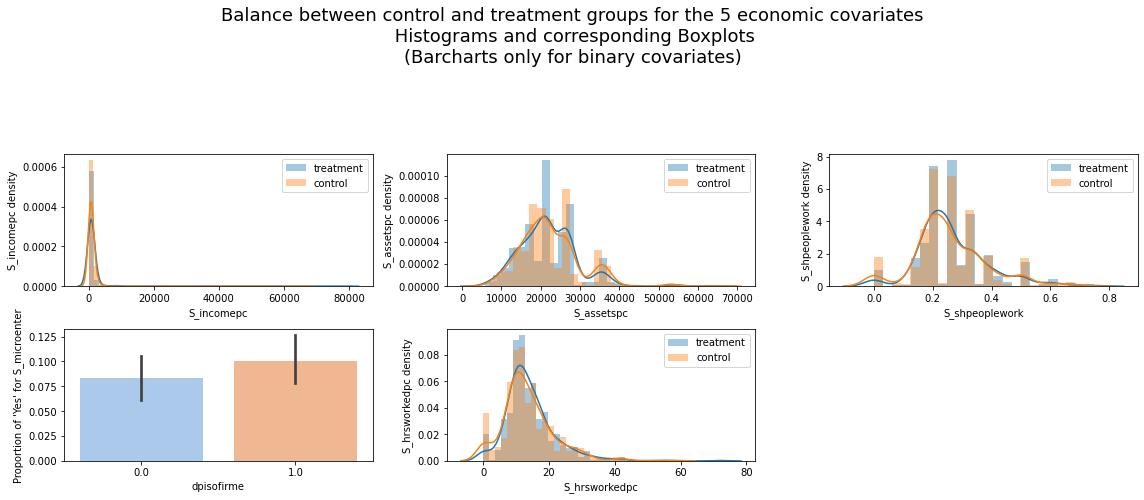

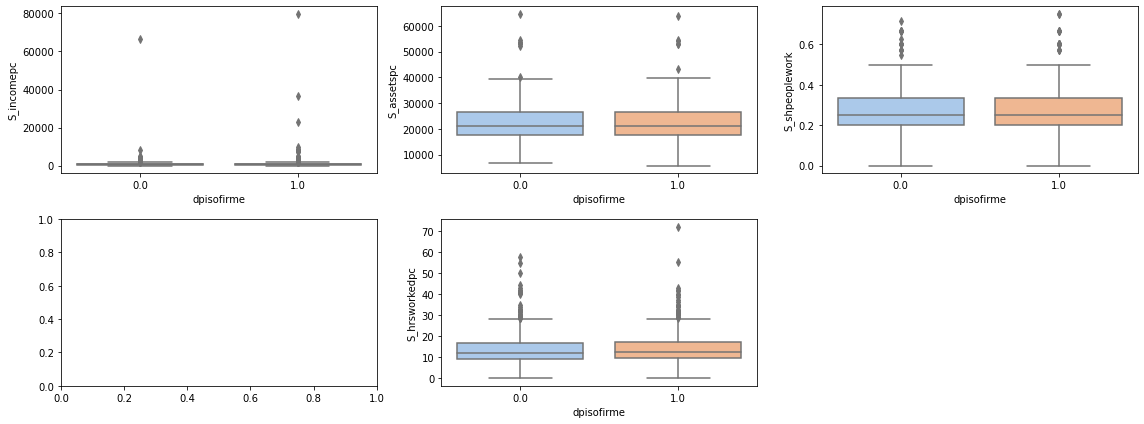

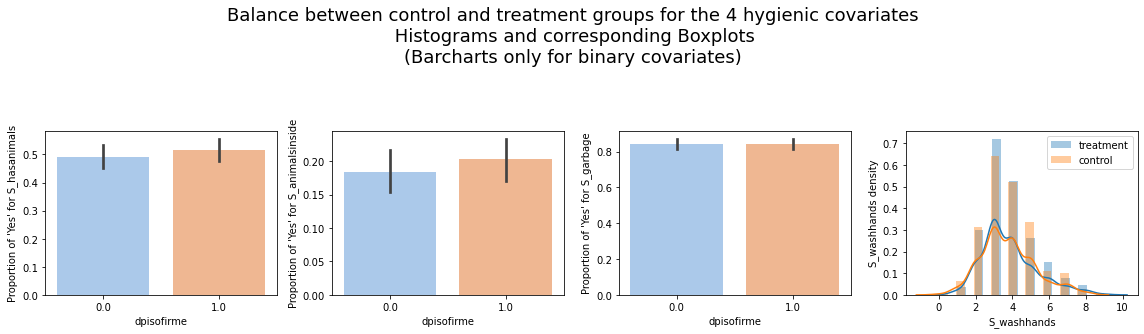

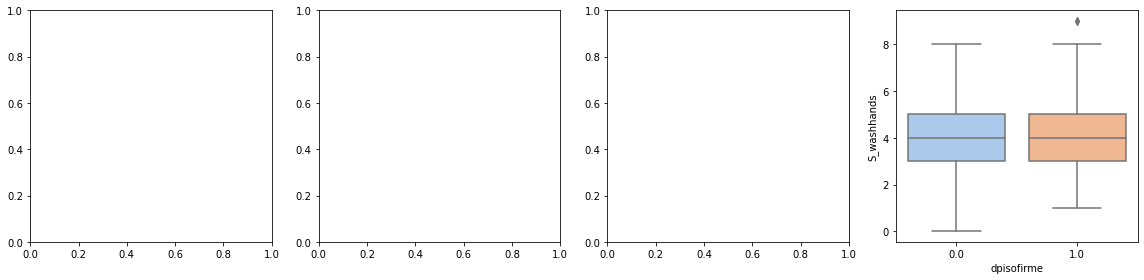

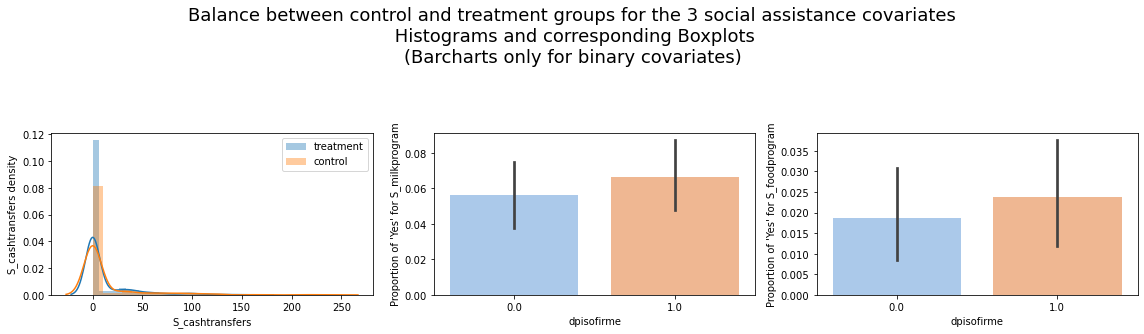

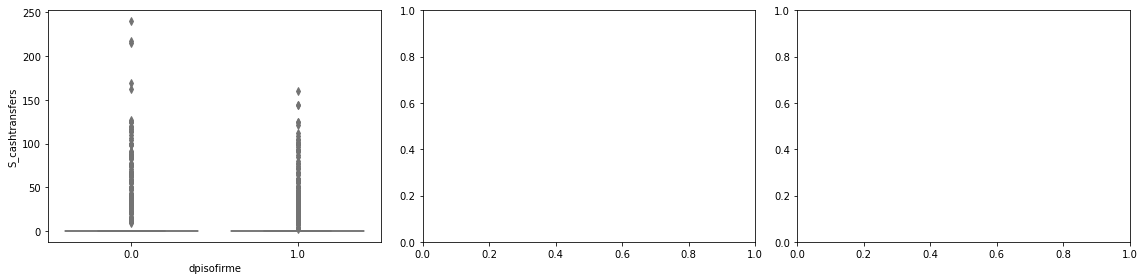

In [27]:
visualize_balance_all(treated_balanced_caliper0001, control_balanced_caliper0001, balanced_caliper0001)

<strong>c) re-evaluation of tables 4 and 6</strong>

In [28]:
final_results(balanced_caliper0001)

,Control group mean,Control group std,Model 1 coeff,Model 1 std,Model 1 percent,Model 1 p-value,Model 2 coeff,Model 2 std,Model 2 percent,Model 2 p-value,Model 3 coeff,Model 3 std,Model 3 percent,Model 3 p-value
Dependent variable,,,,,,,,,,,,,,
Share of rooms with cement floors,0.725,0.366,0.218,0.028,29.919,1.386008e-14,0.214,0.024,29.409,1.786866e-18,0.216,0.025,29.666,2.844514e-18
Cement floor in kitchen,0.672,0.470,0.261,0.034,38.899,2.743717e-14,0.258,0.030,38.393,1.239991e-17,0.261,0.030,38.822,2.015509e-18
Cement floor in dining room,0.701,0.458,0.234,0.035,32.996,1.881922e-11,0.231,0.032,32.587,3.504305e-13,0.230,0.031,32.502,2.440750e-13
Cement floor in bathroom,0.797,0.403,0.128,0.026,15.947,5.628093e-07,0.124,0.020,15.460,5.060438e-10,0.130,0.020,16.177,1.416468e-10
Cement floor in bedroom,0.662,0.473,0.251,0.031,37.574,1.372845e-15,0.246,0.030,36.860,8.727194e-17,0.246,0.029,36.782,2.182575e-17
Satisfaction with floor quality,0.517,0.500,0.225,0.030,44.070,1.134267e-13,0.226,0.030,44.194,6.524238e-14,0.224,0.031,43.901,2.792007e-13
Satisfaction with house quality,0.606,0.489,0.090,0.031,14.945,3.260638e-03,0.089,0.029,14.779,2.356514e-03,0.090,0.030,14.790,2.977297e-03
Satisfaction with quality of life,0.608,0.489,0.108,0.030,17.892,2.905250e-04,0.107,0.028,17.751,1.208061e-04,0.107,0.029,17.775,2.223202e-04
Depression scale (CES-D scale),18.362,9.640,-3.230,0.671,-17.494,1.466057e-06,-3.092,0.634,-16.744,1.077394e-06,-3.132,0.633,-16.960,7.426254e-07


<strong>d) Comparisons, discussion</strong>

<p> The balance for epsilon = 0.0001 is similar to the balance with epsilon = 0.001 and espilon = 0.01. This means that reducing epsilon below 0.01 does not improve the balance. All the results of tables 4 and 6 are still statistically significant as shown with the very small p-values.<br>   

<h1 style="text-align:center" id="Propensity">Part 3 | Creative extension conclusions</h1>
